# Проект. Улучшение baseline-модели

Существует 5 ключевых этапов, которые охватывают создание модели:

- **Этап 1: Подготовка MLflow окружения** - Подготовка и запуск MLflow сервисов в виде 
  *shell*-скрипта: основа для работы с экспериментами и логирования 
  результатов моделей.

- **Этап 2: Исследовательский анализ данных (EDA)** - Проведение тщательного анализа 
  данных для понимания их структуры и особенностей.

- **Этап 3: Генерация признаков и обучение модели** - Создание новых признаков и 
  обучение модели на них после проведения EDA.

- **Этап 4: Отбор признаков и обучение модели** - Выбор наиболее важных признаков и 
  повторное обучение модели.

- **Этап 5: Настройка гиперпараметров и обучение модели** - Настройка гиперпараметров. 


In [ ]:
# Импорты стандартной библиотеки
import json
import logging
import os
import time
import warnings

# Импорты сторонних библиотек
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from autofeat import AutoFeatRegressor
from catboost import CatBoostRegressor
from dotenv import load_dotenv
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    HalvingRandomSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import (
    KBinsDiscretizer,
    PolynomialFeatures,
    RobustScaler,
)

%matplotlib inline

# Настройки matplotlib для отображения графиков
plt.style.use("default")  # Используем стандартный стиль
plt.rcParams["figure.figsize"] = (12, 8)  # Размер по умолчанию
plt.rcParams["figure.dpi"] = 100  # Разрешение

# Подавление предупреждений
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Подавление специфичных варнингов matplotlib
warnings.filterwarnings("ignore", message=".*categorical units.*")

# === Вспомогательные функции логгирования ===

def log_eda_summary(eda_insights, verbose=False):
    """
    Логирование результатов EDA анализа
    """
    # Основная структурированная запись
    logger.info(f"EDA analysis completed - "
                f"execution_time={eda_insights['execution_time']:.2f}s, "
                f"dataset_shape={eda_insights['basic_info']['shape']}, "
                f"missing_values={eda_insights['basic_info']['missing_values']}, "
                f"memory_usage_mb={eda_insights['basic_info']['memory_usage']:.1f}, "
                f"feature_types={eda_insights['feature_types']}")
    
    # Детальная информация только при verbose=True
    if verbose:
        logger.debug(f"Detailed EDA insights - "
                    f"outliers_info={eda_insights['outliers_info']}, "
                    f"dtypes_distribution={eda_insights['basic_info']['dtypes']}")
    
    return eda_insights

def log_feature_engineering_summary(features_info, verbose=False):
    """
    Логирование результатов генерации признаков
    """
    logger.info(f"Feature engineering completed - "
                f"sklearn_features={features_info['sklearn_features']}, "
                f"autofeat_features={features_info['autofeat_features']}, "
                f"total_features={features_info['total_features']}, "
                f"execution_time={features_info['execution_time']:.2f}s")
    
    if verbose:
        logger.debug(f"Feature engineering details - "
                    f"sklearn_names_count={features_info['sklearn_names_count']}, "
                    f"autofeat_names_count={features_info['autofeat_names_count']}")

def log_model_performance_summary(model_name, metrics, verbose=False):
    """
    Логирование результатов модели
    """
    logger.info(f"{model_name} training completed - "
                f"RMSE={metrics['rmse']:,.0f}, "
                f"R²={metrics['r2']:.3f}, "
                f"MAE={metrics['mae']:,.0f}")
    
    if verbose:
        logger.debug(f"{model_name} detailed metrics - {metrics}")

def log_mlflow_summary(stage_name, params=None, metrics=None, artifacts=None):
    """
    Логирование в MLflow
    """
    # Батчевое логирование параметров
    if params:
        mlflow.log_params(params)
    
    # Батчевое логирование метрик
    if metrics:
        mlflow.log_metrics(metrics)
    
    # Логирование артефактов
    if artifacts:
        for artifact_path, artifact_name in artifacts.items():
            mlflow.log_artifact(artifact_path, artifact_name)
    
    logger.info(f"MLflow logging completed for {stage_name}")


def plot_feature_importance(model, feature_names, title="Feature Importance", 
                          top_n=20, save_path=None):
    """
    Создание графика важности признаков
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"{title} (Top {top_n})")
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), 
               [feature_names[i] for i in indices], 
               rotation=45, ha='right')
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return plt.gcf()

warnings.filterwarnings("ignore", message=".*parsable as floats.*")

# Подавление варнингов библиотек
logging.getLogger("catboost").setLevel(logging.ERROR)
logging.getLogger("mlflow.utils.requirements_utils").setLevel(logging.ERROR)
logging.getLogger("mlflow.models.model").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("seaborn").setLevel(logging.ERROR)

# Настройка логирования для проекта
def setup_logging():
    """Настройка логирования для проекта"""
    # Создаем логгер для проекта
    logger = logging.getLogger("ml_project")
    logger.setLevel(logging.INFO)
    
    # Удаляем существующие обработчики
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    
    # Отключаем propagation для избежания дублирования
    logger.propagate = False
    
    # Создаем форматтер
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    
    # Консольный обработчик
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    
    # Файловый обработчик
    file_handler = logging.FileHandler('ml_project.log', encoding='utf-8')
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    
    return logger

# Инициализация логгера
logger = setup_logging()

# Настройки визуализации
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 64)
sns.set_theme(style="ticks", palette="pastel")

# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
CV_FOLDS = 2

/home/mle-user/.venv/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
/home/mle-user/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/mle-user/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


ОПИСАНИЕ ФУНКЦИЙ МАШИННОГО ОБУЧЕНИЯ

Данный блок содержит три ключевые функции для ML pipeline:

1. **feature_engineering_pipeline()**
   - Pipeline генерации признаков
   - Комбинация sklearn.preprocessing + AutoFeat
   - RobustScaler + KBinsDiscretizer + PolynomialFeatures
   - Автоматическое создание новых признаков через AutoFeat
   - Fallback механизм при ошибках AutoFeat
   - Возвращает: (X_train, X_test, preprocessor, autofeat_model, feature_names)

2. **feature_selection_mlxtend()**
   - Отбор признаков с использованием MLXTEND
   - Forward + Backward Sequential Feature Selection
   - Создание графиков важности признаков и SFS результатов
   - Выбор лучшего метода: пересечение vs объединение признаков
   - Сохранение результатов в fs_assets/ директории
   - Возвращает: (selected_features, sfs_forward, sfs_backward)

3. **hyperparameter_tuning_dual()**
   - Двойная настройка гиперпараметров
   - HalvingRandomSearchCV + Optuna с MLflowCallback
   - Автоматический выбор лучшего метода по производительности
   - Интеграция с MLflow для логирования trials
   - SuccessiveHalvingPruner для раннего прекращения плохих trials
   - Возвращает: (best_params, best_score, best_method, rscv, study)


In [ ]:
def feature_engineering_pipeline(
    features_train, features_test, target_train, verbose=True
):
    """
    Pipeline генерации признаков с использованием sklearn.preprocessing + autofeat
    """
    start_time = time.time()
    
    if verbose:
        logger.info("Генерация признаков")
        logger.info(f"Исходный размер: {features_train.shape}")
    
    # Определение типов признаков
    numeric_features = features_train.select_dtypes(
        include=[np.number]
    ).columns.tolist()
    categorical_features = features_train.select_dtypes(
        include=['object', 'category']
    ).columns.tolist()
    
    if verbose:
        logger.info(f"Числовых признаков: {len(numeric_features)}")
        logger.info(f"Категориальных признаков: {len(categorical_features)}")
    
    # === SKLEARN PIPELINE ===
    
    # RobustScaler для устойчивости к выбросам
    robust_scaler = RobustScaler()
    
    # KBinsDiscretizer с количеством бинов
    k_bins_discretizer = KBinsDiscretizer(
        n_bins=5,
        encode="ordinal", 
        strategy="uniform"
    )
    
    # PolynomialFeatures для создания полиномиальных признаков
    poly_features = PolynomialFeatures(
        degree=3,
        include_bias=False, 
        interaction_only=False
    )
    
    # ColumnTransformer с параллелизацией
    sklearn_preprocessor = ColumnTransformer(
        transformers=[
            ("rs", robust_scaler, numeric_features),
            ("kbd", k_bins_discretizer, numeric_features),
            ("pf", poly_features, numeric_features),
        ],
        remainder="passthrough",
        n_jobs=-1,
        verbose_feature_names_out=True  
    )
    
    # === ПРИМЕНЕНИЕ SKLEARN PIPELINE ===
    if verbose:
        logger.info("Применение sklearn Pipeline.")
    
    # Применение трансформаций
    features_train_sklearn = sklearn_preprocessor.fit_transform(features_train)
    features_test_sklearn = sklearn_preprocessor.transform(features_test)
    
    # Получение имен признаков
    feature_names_sklearn = sklearn_preprocessor.get_feature_names_out()
    
    sklearn_time = time.time() - start_time
    
    if verbose:
        logger.info(
            f"sklearn Pipeline применен за {sklearn_time:.2f}s: "
            f"{features_train_sklearn.shape}"
        )
    
    # === AUTOFEAT ГЕНЕРАЦИЯ ===
    if verbose:
        logger.info("Применение autofeat...")
    
    autofeat_start = time.time()
    
    try:
        af = AutoFeatRegressor(
            feateng_cols=numeric_features,
            feateng_steps=2,
            max_gb=16,
            n_jobs=-1,
            transformations=["exp", "log"],
            verbose=False
        )
        
        X_train_autofeat = af.fit_transform(
            features_train[numeric_features], target_train.values
        )
        X_test_autofeat = af.transform(features_test[numeric_features])
        
        autofeat_time = time.time() - autofeat_start
        
        if verbose:
            logger.info(f"✅ Autofeat завершен за {autofeat_time:.2f}s")
            new_feats_count = len(af.new_feat_cols_) if af is not None else 0
            logger.info(f"Новых признаков создано: {new_feats_count}")
            logger.info(f"Итоговый размер autofeat: {X_train_autofeat.shape}")
            
    except Exception as e:
        logger.warning(f"⚠️ Ошибка в autofeat: {e}")
        logger.info("🔄 Используем fallback к sklearn pipeline")
        
        # Fallback к sklearn pipeline
        X_train_autofeat = np.empty((features_train_sklearn.shape[0], 0))
        X_test_autofeat = np.empty((features_test_sklearn.shape[0], 0))
        af = None
        
        autofeat_time = time.time() - autofeat_start
        if verbose:
            logger.info(f"Fallback применен за {autofeat_time:.2f}s")
    
    # Объединение признаков с обработкой имен
    # Создание DataFrame с именами признаков
    sklearn_df_train = pd.DataFrame(features_train_sklearn, columns=feature_names_sklearn)
    sklearn_df_test = pd.DataFrame(features_test_sklearn, columns=feature_names_sklearn)
    
    # Обработка autofeat признаков
    if af is not None and hasattr(af, 'new_feat_cols_') and len(af.new_feat_cols_) > 0:
        # AutoFeat создал новые признаки
        autofeat_df_train = pd.DataFrame(X_train_autofeat, columns=af.new_feat_cols_)
        autofeat_df_test = pd.DataFrame(X_test_autofeat, columns=af.new_feat_cols_)
        
        # Объединение через pd.concat
        features_train_combined = pd.concat([sklearn_df_train, autofeat_df_train], axis=1)
        features_test_combined = pd.concat([sklearn_df_test, autofeat_df_test], axis=1)
        
        combined_feature_names = list(feature_names_sklearn) + list(af.new_feat_cols_)
    else:
        # Fallback - используем только sklearn признаки
        features_train_combined = sklearn_df_train
        features_test_combined = sklearn_df_test
        combined_feature_names = list(feature_names_sklearn)
    
    # Проверяем соответствие размеров
    sklearn_features_count = features_train_sklearn.shape[1]
    autofeat_features_count = (X_train_autofeat.shape[1] 
                              if af is not None and hasattr(af, 'new_feat_cols_') 
                              else 0)
    total_features_count = features_train_combined.shape[1]
    
    # Создаем структурированную информацию для логирования
    features_info = {
        'sklearn_features': sklearn_features_count,
        'autofeat_features': autofeat_features_count,
        'total_features': total_features_count,
        'sklearn_names_count': len(feature_names_sklearn),
        'autofeat_names_count': (len(af.new_feat_cols_) 
                               if af is not None and hasattr(af, 'new_feat_cols_') 
                               else 0),
        'execution_time': time.time() - start_time
    }
    
    # Проверяем соответствие размеров
    if len(combined_feature_names) != total_features_count:
        logger.warning(
            f"⚠️ Несоответствие размеров: names={len(combined_feature_names)}, "
            f"features={total_features_count}"
        )
    
    # Логирование результатов генерации признаков
    log_feature_engineering_summary(features_info, verbose=verbose)
    
    # Возвращаем как массивы для совместимости
    return (features_train_combined.values, features_test_combined.values, 
            sklearn_preprocessor, af, combined_feature_names)


def feature_selection_mlxtend(X_train, y_train, feature_names, verbose=True):
    """
    Отбор признаков с mlxtend
    """
    start_time = time.time()
    
    if verbose:
        logger.info("Отбор признаков с MLXTEND")
        logger.info(f"Исходное количество признаков: {len(feature_names)}")
    
    # Используем обученную модель для получения важности признаков
    if verbose:
        logger.info("Используем обученную модель для отбора признаков")
        logger.info(f"Всего признаков: {len(feature_names)}")
    
    # Создаем модель для получения feature_importances
    model = CatBoostRegressor(verbose=False)
    model.fit(X_train, y_train)
    
    # Получение важности признаков
    top_features = (
        pd.Series(model.feature_importances_, index=feature_names)
        .sort_values(ascending=False)
        .head(10)
    )
    top_features = top_features.index.tolist()
    
    # Используем все признаки для дальнейшей работы
    X_train_filtered = X_train
    feature_names_filtered = feature_names
    
    if verbose:
        logger.info("Предварительный отбор: топ-10 признаков из них топ-5 важных")
        feature_importance = pd.Series(model.feature_importances_, index=feature_names)
        for i, (feature, importance) in enumerate(feature_importance.head(5).items()):
            logger.info(f"   {i+1}. {feature}: {importance:.4f}")
    
    # Создаем DataFrame для удобства работы с отфильтрованными признаками
    # Используем только доступные признаки
    X_top_df = pd.DataFrame(X_train_filtered[:, :len(feature_names_filtered)], 
                           columns=feature_names_filtered)[top_features]
    
    # Создаем директорию для результатов
    os.makedirs('fs_assets', exist_ok=True)
    
    # Forward Selection
    if verbose:
        logger.info("Forward Selection.")
    
    sfs_forward = SFS(
        CatBoostRegressor(verbose=False, iterations=100),
        k_features=5,
        forward=True,
        floating=False,
        scoring="neg_root_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    
    sfs_forward.fit(X_top_df, y_train)
    forward_features = list(sfs_forward.k_feature_names_)
    forward_score = sfs_forward.k_score_
    
    # Backward Selection
    if verbose:
        logger.info("Backward Selection.")
    
    sfs_backward = SFS(
        CatBoostRegressor(verbose=False, iterations=100),
        k_features=5,
        forward=False,
        floating=False,
        scoring="neg_root_mean_squared_error",
        cv=2,
        n_jobs=-1
    )
    
    sfs_backward.fit(X_top_df, y_train)
    backward_features = list(sfs_backward.k_feature_names_)
    backward_score = sfs_backward.k_score_
    
    # === СОЗДАНИЕ ГРАФИКОВ SFS И ВАЖНОСТИ ПРИЗНАКОВ ===
    if verbose:
        logger.info("Создание графиков SFS и важности признаков.")
    
    # Создание графиков SFS
    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    
    # График Forward Selection
    plot_sfs(sfs_forward.get_metric_dict(), kind="std_dev")
    plt.title("Sequential Forward Selection (w. StdDev)")
    plt.grid(True)
    plt.savefig('fs_assets/sfs_forward.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # График Backward Selection
    plot_sfs(sfs_backward.get_metric_dict(), kind="std_dev")
    plt.title("Sequential Backward Selection (w. StdDev)")
    plt.grid(True)
    plt.savefig('fs_assets/sfs_backward.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # === ГРАФИКИ ВАЖНОСТИ ПРИЗНАКОВ ===
    if verbose:
        logger.info("Создание графиков важности признаков.")
    
    # График важности признаков до отбора
    plot_feature_importance(
        model, 
        feature_names_filtered, 
        title="Feature Importance (Before Selection)",
        save_path='fs_assets/feature_importance_before.png'
    )
    plt.show()
    
    # График важности признаков после отбора (Forward)
    if len(forward_features) > 0:
        # Создаем модель на отобранных признаках для графика важности
        model_forward = CatBoostRegressor(verbose=False, iterations=200)
        X_forward_selected = X_train_filtered[:, 
            [feature_names_filtered.index(f) for f in forward_features]]
        model_forward.fit(X_forward_selected, y_train)
        
        plot_feature_importance(
            model_forward, 
            forward_features, 
            title="Feature Importance (Forward Selection)",
            save_path='fs_assets/feature_importance_forward.png'
        )
        plt.show()
    
    # График важности признаков после отбора (Backward)
    if len(backward_features) > 0:
        # Создаем модель на отобранных признаках для графика важности
        model_backward = CatBoostRegressor(verbose=False, iterations=200)
        X_backward_selected = X_train_filtered[:, 
            [feature_names_filtered.index(f) for f in backward_features]]
        model_backward.fit(X_backward_selected, y_train)
        
        plot_feature_importance(
            model_backward, 
            backward_features, 
            title="Feature Importance (Backward Selection)",
            save_path='fs_assets/feature_importance_backward.png'
        )
        plt.show()
        
    # === АНАЛИЗ РЕЗУЛЬТАТОВ ОТБОРА ПРИЗНАКОВ ===
    if verbose:
        logger.info("Анализ результатов отбора признаков.")
    
    # Объединяем результаты двух методов
    intersection_features = list(set(forward_features) & set(backward_features))
    union_features = list(set(forward_features) | set(backward_features))
    
    # === СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
    # Создаем CSV файлы с результатами
    sfs_forward_df = pd.DataFrame.from_dict(sfs_forward.get_metric_dict()).T
    sfs_backward_df = pd.DataFrame.from_dict(sfs_backward.get_metric_dict()).T
    
    sfs_forward_df.to_csv('fs_assets/sfs_forward_results.csv')
    sfs_backward_df.to_csv('fs_assets/sfs_backward_results.csv')
    
    total_time = time.time() - start_time
    
    # Тестируем оба набора признаков для выбора лучшего
    if len(intersection_features) > 0:
        # Тестируем пересечение
        cb_intersection = CatBoostRegressor(
            iterations=100,
            random_seed=RANDOM_STATE,
            verbose=False,
            depth=6,
            learning_rate=0.1
        )
        cb_intersection.fit(X_top_df[intersection_features], y_train)
        intersection_score = cb_intersection.score(X_top_df[intersection_features], y_train)
    else:
        intersection_score = float('-inf')
    
    # Тестируем объединение
    cb_union = CatBoostRegressor(
        iterations=100,
        random_seed=RANDOM_STATE,
        verbose=False,
        depth=6,
        learning_rate=0.1
    )
    cb_union.fit(X_top_df[union_features], y_train)
    union_score = cb_union.score(X_top_df[union_features], y_train)
    
    # Выбираем лучший набор признаков
    if intersection_score > union_score and len(intersection_features) > 0:
        selected_features = intersection_features
        best_method = "intersection"
    else:
        selected_features = union_features
        best_method = "union"
    
    if verbose:
        logger.info(f"Forward Selection: {len(forward_features)} признаков "
                  f"(RMSE: {-forward_score:.3f})")
        logger.info(f"Backward Selection: {len(backward_features)} признаков "
                  f"(RMSE: {-backward_score:.3f})")
        logger.info(
            f"Пересечение: {len(intersection_features)} признаков (R²: {intersection_score:.3f})"
        )
        logger.info(f"Объединение: {len(union_features)} признаков (R²: {union_score:.3f})")
        logger.info(f"Выбран метод: {best_method} с {len(selected_features)} признаками")
        logger.info(f"Отбор признаков завершен за {total_time:.2f}s")
    
    # Сохраняем финальный список отобранных признаков
    with open('fs_assets/selected_features.txt', 'w', encoding='utf-8') as f:
        f.write(','.join(selected_features))
    
    return selected_features, sfs_forward, sfs_backward


def hyperparameter_tuning_dual(X_train, y_train, experiment_id, verbose=True):
    """
    Двойная настройка гиперпараметров:
    Optuna + RandomizedSearchCV с MLflowCallback 
    """
    start_time = time.time()
    
    if verbose:
        logger.info("Двойная настройка гиперпараметров")
    
    # === МЕТОД 1: HALVINGRANDOMSEARCHCV ===
    if verbose:
        logger.info("1. HalvingRandomSearchCV...")
    
    rscv_start = time.time()
    
    # Используем scipy.stats для распределений
    param_distributions = {
        'learning_rate': uniform(0.01, 0.19),
        'depth': randint(3, 8),
        'iterations': randint(800, 1200),
        'l2_leaf_reg': uniform(1, 7),
        'min_data_in_leaf': randint(1, 9),
        'max_ctr_complexity': randint(1, 3)
    }
    
    halving_random = HalvingRandomSearchCV(
        CatBoostRegressor(random_seed=RANDOM_STATE, verbose=False),
        param_distributions=param_distributions,
        cv=3,  # Увеличено с 2 до 3 для лучшей стабильности
        factor=2,
        min_resources=20,
        max_resources=100,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    halving_random.fit(X_train, y_train)
    rscv_params = halving_random.best_params_
    rscv_score = halving_random.best_score_
    rscv_time = time.time() - rscv_start
    
    if verbose:
        logger.info(
            f"HalvingRandomSearchCV завершен за {rscv_time:.2f}s: "
            f"RMSE = {-rscv_score:.3f}"
        )
    
    # === МЕТОД 2: OPTUNA С MLFLOWCALLBACK ===
    if verbose:
        logger.info("2. Optuna настройка с MLflowCallback...")
    
    optuna_start = time.time()
    
    # MLflowCallback для Optuna
    from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
    from optuna.integration.mlflow import MLflowCallback
        
    # Получаем текущий активный run для создания дочерних runs
    current_run = mlflow.active_run()
    parent_run_id = current_run.info.run_id if current_run else None
        
    mlflc = MLflowCallback(
        tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
        metric_name="RMSE",
        create_experiment=False,
        mlflow_kwargs={
            "experiment_id": experiment_id,
            "nested": True,
            "tags": {MLFLOW_PARENT_RUN_ID: parent_run_id} if parent_run_id else {},
        },
    )
        
    callback_available = True
        
    def objective(trial):
        # Набор параметров для настройки
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 3, 8),
            "iterations": trial.suggest_int("iterations", 500, 1000),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
            "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 1, 8),
            "random_seed": RANDOM_STATE,
            "verbose": False,
        }
        
        model = CatBoostRegressor(**params)
        
        # Используем cross_val_score для оценки
        cv_scores = cross_val_score(
            model, X_train, y_train,
            scoring="neg_root_mean_squared_error",
            cv=3,  # Увеличено с 2 до 3 для лучшей стабильности
            n_jobs=-1
        )
        
        return cv_scores.mean()
    
    # Создаем study с SuccessiveHalvingPruner
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
        pruner=optuna.pruners.SuccessiveHalvingPruner(
            min_resource=1,
            reduction_factor=2,
            min_early_stopping_rate=0
        )
    )
    
    # Настройка с MLflowCallback 
    callbacks = [mlflc] if callback_available else []
    study.optimize(objective, n_trials=10, callbacks=callbacks, show_progress_bar=verbose)
    
    optuna_params = study.best_params
    optuna_score = study.best_value
    optuna_time = time.time() - optuna_start
    
    if verbose:
        logger.info(f"Optuna завершен за {optuna_time:.2f}s: RMSE = {-optuna_score:.3f}")
    
    # === ВЫБОР ЛУЧШЕГО МЕТОДА ===
    if rscv_score > optuna_score:
        best_params = rscv_params
        best_score = rscv_score
        best_method = "HalvingRandomSearchCV"
        best_time = rscv_time
    else:
        best_params = optuna_params
        best_score = optuna_score
        best_method = "Optuna"
        best_time = optuna_time
    
    total_time = time.time() - start_time
    
    if verbose:
        logger.info(f"Лучший метод: {best_method}")
        logger.info(f"Лучший RMSE: {-best_score:.3f}")
        logger.info(f"Время настройки: {best_time:.2f}s")
        logger.info(f"Общее время: {total_time:.2f}s")
        logger.info("Лучшие параметры:")
        for param, value in best_params.items():
            logger.info(f"   {param}: {value}")
    
    return best_params, best_score, best_method, halving_random, study

В начале анализа мы импортируем необходимые пакеты и загружаем данные, 
которые станут основой для создания модели и её последующего обучения:

In [ ]:
# Настройки путей
PROJECT_ROOT = ".."
# Используем исходные данные
DATA_PATH = f"{PROJECT_ROOT}/data/initial_data_set.csv"
ENV_PATH = f"{PROJECT_ROOT}/.env"

# Директории для результатов
CV_RESULTS_DIR = "cv_results"
MODELS_DIR = "models"
PLOTS_DIR = "plots"
REPORTS_DIR = "reports"

# MLflow настройки
EXPERIMENT_NAME = "baseline_model_improvement_REPP"

# Загрузка окружения 
load_dotenv(dotenv_path=ENV_PATH, override=True)

TRACKING_SERVER_HOST = os.getenv(
    "MLFLOW_TRACKING_HOST", os.getenv("TRACKING_SERVER_HOST", "127.0.0.1")
)
TRACKING_SERVER_PORT = int(
    os.getenv("MLFLOW_TRACKING_PORT", os.getenv("TRACKING_SERVER_PORT", "5000"))
)

# Настройка S3 
os.environ["MLFLOW_S3_ENDPOINT_URL"] = os.getenv("MLFLOW_S3_ENDPOINT_URL")
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

# Настройка MLflow
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
logger.info(f"MLflow подключен: {experiment_id}")

# Загрузка baseline метрик
with open("models/baseline_metrics.json") as json_file:
    baseline_metrics = json.load(json_file)

baseline_rmse = baseline_metrics["rmse_test"]
baseline_r2 = baseline_metrics["r2_test"]

logger.info(f"Baseline RMSE: {baseline_rmse:.3f}")
logger.info(f"Baseline R²: {baseline_r2:.3f}")

# Загрузка данных
def load_and_validate_data(data_path):
    """Загрузка и валидация данных"""
    df = pd.read_csv(data_path)
    
    # Критические проверки
    assert not df.empty, "DataFrame пустой"
    assert "price" in df.columns, "Целевая переменная 'price' не найдена"
    
    logger.info(f"Загружено данных: {len(df):,} строк × {df.shape[1]} колонок")
    
    # Настройка dtypes для производительности
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].dtype == "int64":
            if df[col].min() >= -2147483648 and df[col].max() <= 2147483647:
                df[col] = df[col].astype("int32")
        elif df[col].dtype == "float64":
            df[col] = df[col].astype("float32")
    
    logger.info(f"Настроены dtypes для {len(numeric_cols)} колонок")
    return df

# Загрузка данных
df = load_and_validate_data(DATA_PATH)

# Удаление ненужных столбцов 
cols_to_drop = ["id", "building_id"]
df = df.drop(cols_to_drop, axis=1)

2025-09-21 21:04:15 - ml_project - INFO - MLflow подключен: 2
2025-09-21 21:04:15 - ml_project - INFO - Baseline RMSE: 4157670
2025-09-21 21:04:15 - ml_project - INFO - Baseline R²: 0.880
2025-09-21 21:04:16 - ml_project - INFO - Загружено данных: 120,118 строк × 18 колонок
2025-09-21 21:04:16 - ml_project - INFO - Настроены dtypes для 15 колонок


#### Этап 2: Исследовательский анализ данных (EDA)

##### Базовый анализ данных

Проведем краткий анализ данных и убедимся, проведена предварительная обработка данных,
затронув пропущенные значения и преобразование типов данных

In [3]:
logger.info("Этап 2: Исследовательский анализ данных (EDA)")

# Выполнение EDA анализа
start_time = time.time()

logger.info(f"Размер данных: {len(df):,} строк × {df.shape[1]} колонок")

# Отображение базовой информации о данных
print("Информация о датасете:")
df.info()

2025-09-21 21:04:43 - ml_project - INFO - Этап 2: Исследовательский анализ данных (EDA)
2025-09-21 21:04:43 - ml_project - INFO - Размер данных: 120,118 строк × 16 колонок


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120118 entries, 0 to 120117
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   floor           120118 non-null  int32  
 1   kitchen_area    120118 non-null  float32
 2   living_area     120118 non-null  float32
 3   rooms           120118 non-null  int32  
 4   is_apartment    120118 non-null  bool   
 5   studio          120118 non-null  bool   
 6   total_area      120118 non-null  float32
 7   price           120118 non-null  int32  
 8   build_year      120118 non-null  int32  
 9   building_type   120118 non-null  int32  
 10  latitude        120118 non-null  float32
 11  longitude       120118 non-null  float32
 12  ceiling_height  120118 non-null  float32
 13  flats_count     120118 non-null  int32  
 14  floors_total    120118 non-null  int32  
 15  has_elevator    120118 non-null  bool   
dtypes: bool(3), float32(6), int32(7)


Пропущенные значения

In [4]:
print("\nПроверка пропущенных значений:")
missing_summary = df.isnull().sum().sort_values(ascending=False)
print(missing_summary)


Проверка пропущенных значений:
floor             0
kitchen_area      0
living_area       0
rooms             0
is_apartment      0
studio            0
total_area        0
price             0
build_year        0
building_type     0
latitude          0
longitude         0
ceiling_height    0
flats_count       0
floors_total      0
has_elevator      0
dtype: int64


In [5]:
print("\nТипы данных:")
print(df.dtypes.value_counts())


Типы данных:
int32      7
float32    6
bool       3
Name: count, dtype: int64


##### Анализ признаков для модели

Следующий шаг - изучить признаки, которые позже будут участвовать в процессе 
моделирования. Давайте отобразим первую строку DataFrame, чтобы иметь один пример, 
представленный одним объектом недвижимости:

In [6]:
print("\nПример данных:")
features = df.drop('price', axis=1)
features.head(5)


Пример данных:


,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,build_year,building_type,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,9,9.90,19.90,1,False,False,35.099998,1965,6,55.717113,37.781120,2.64,84,12,True
1,7,0.00,16.60,1,False,False,43.000000,2001,2,55.794849,37.608013,3.00,97,10,True
2,9,9.00,32.00,2,False,False,56.000000,2000,4,55.740040,37.761742,2.70,80,10,True
3,9,0.00,0.00,2,False,False,51.009998,2017,4,55.724728,37.743069,2.70,192,17,True
4,1,6.18,29.34,2,False,False,44.520000,1964,4,55.795589,37.722622,2.64,180,5,False


Теперь мы можем начать рассматривать признаки с разных углов. Давайте посмотрим на 
общую площадь в зависимости от типов зданий с дополнительной фильтрацией по 
количеству комнат в квартире:

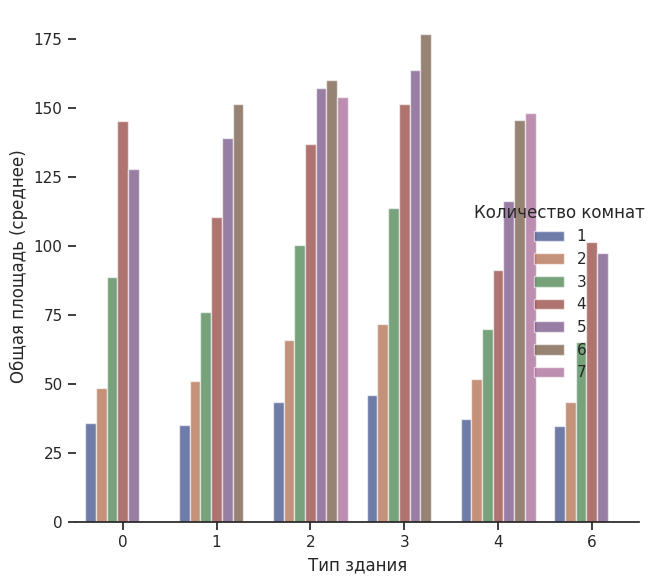

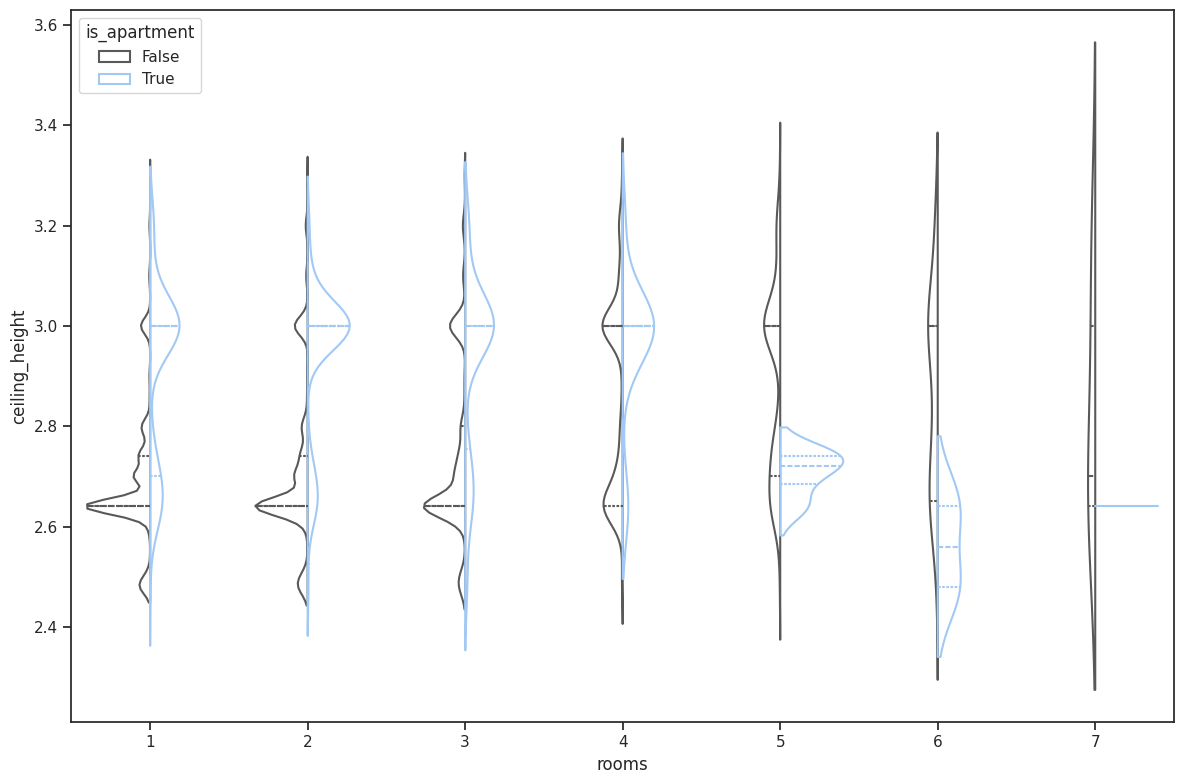

In [7]:
# Создаем директорию для графиков
os.makedirs('plots', exist_ok=True)

# График общей площади по типам зданий и количеству комнат
if 'building_type' in features.columns and 'rooms' in features.columns:
    cat_plot = sns.catplot(
        data=features,
        kind="bar",
        x="building_type",
        y="total_area",
        hue="rooms",
        errorbar=None,
        palette="dark",
        alpha=0.6,
        height=6,
    )
    cat_plot.despine(left=True)
    cat_plot.set_axis_labels("Тип здания", "Общая площадь (среднее)")
    cat_plot.legend.set_title("Количество комнат")
    plt.tight_layout()
    plt.savefig('plots/total_area_by_building_type.png', dpi=150, bbox_inches='tight')
    plt.show()

# Анализ высоты потолков в зависимости от количества комнат
if 'ceiling_height' in features.columns and 'is_apartment' in features.columns:
    violin_plot = sns.violinplot(
        data=features,
        x="rooms",
        y="ceiling_height",
        hue="is_apartment",
        split=True,
        inner="quart",
        fill=False,
        palette={True: "b", False: ".35"},
    )
    plt.tight_layout()
    plt.savefig('plots/ceiling_height_by_rooms.png', dpi=150, bbox_inches='tight')
    plt.show()

Далее мы можем рассмотреть данные с статистической точки зрения: построив 
корреляционную матрицу признаков в виде тепловой карты:

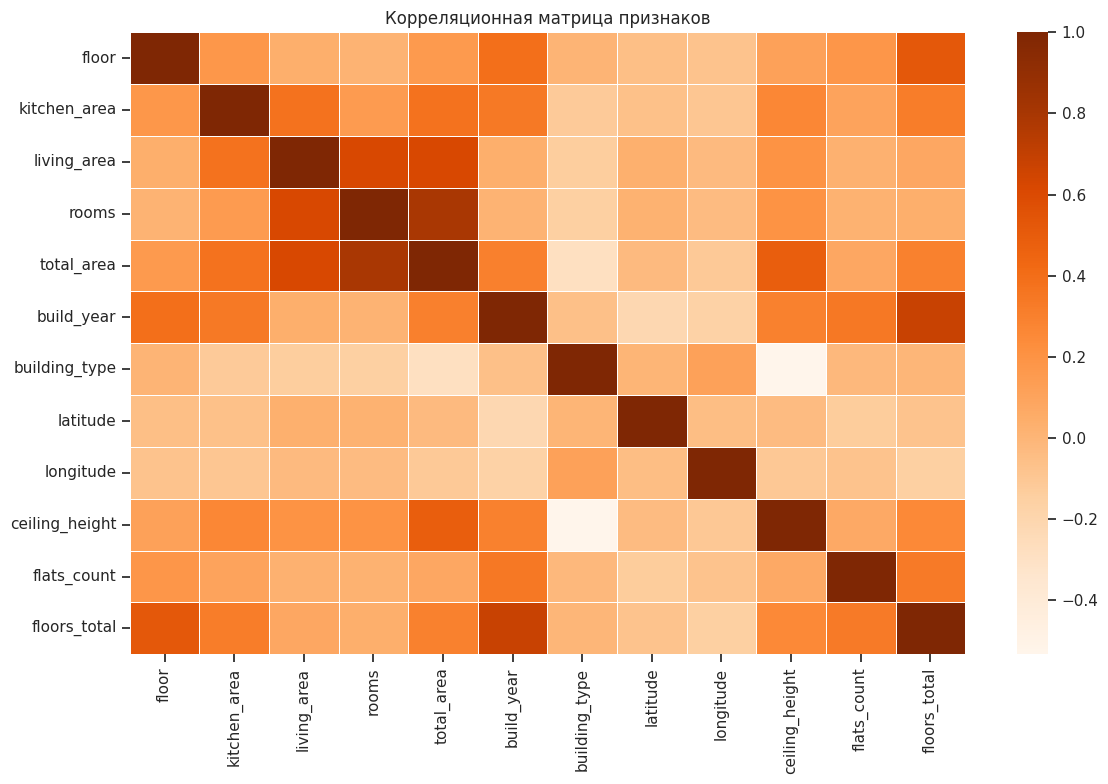

Топ-5 корреляций с общей площадью:
rooms             0.790948
living_area       0.618574
ceiling_height    0.485287
kitchen_area      0.372023
build_year        0.301856
Name: total_area, dtype: float64


In [8]:
# Исключаем булевые признаки для корреляционного анализа
features_for_corr = features.select_dtypes(include=[np.number])
if 'studio' in features_for_corr.columns:
    features_for_corr = features_for_corr.drop('studio', axis=1)

corr_matrix = features_for_corr.corr()
corr_heatmap = sns.heatmap(
    corr_matrix,
    linewidth=0.5,
    cmap="Oranges",
)
corr_heatmap.xaxis.tick_bottom()
corr_heatmap.yaxis.tick_left()
corr_heatmap.set(title="Корреляционная матрица признаков")
plt.tight_layout()
plt.savefig('plots/correlation_matrix_features.png', dpi=150, bbox_inches='tight')
plt.show()

# Топ-5 корреляций с общей площадью
if 'total_area' in corr_matrix.columns:
    corr_total_area_5 = (
        corr_matrix["total_area"].abs().sort_values(ascending=False)[1:].head()
    )
    print("Топ-5 корреляций с общей площадью:")
    print(corr_total_area_5)

Мы также можем рассмотреть булевые и другие столбцы отдельно. Давайте построим 
гистограммы для численных признаков:

Найдено числовых колонок: 12
Колонки: ['floor', 'kitchen_area', 'living_area', 'rooms', 'total_area', 'build_year', 'building_type', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total']
Размер df_nobool: (120118, 12)
Типы данных: int32      6
float32    6
Name: count, dtype: int64


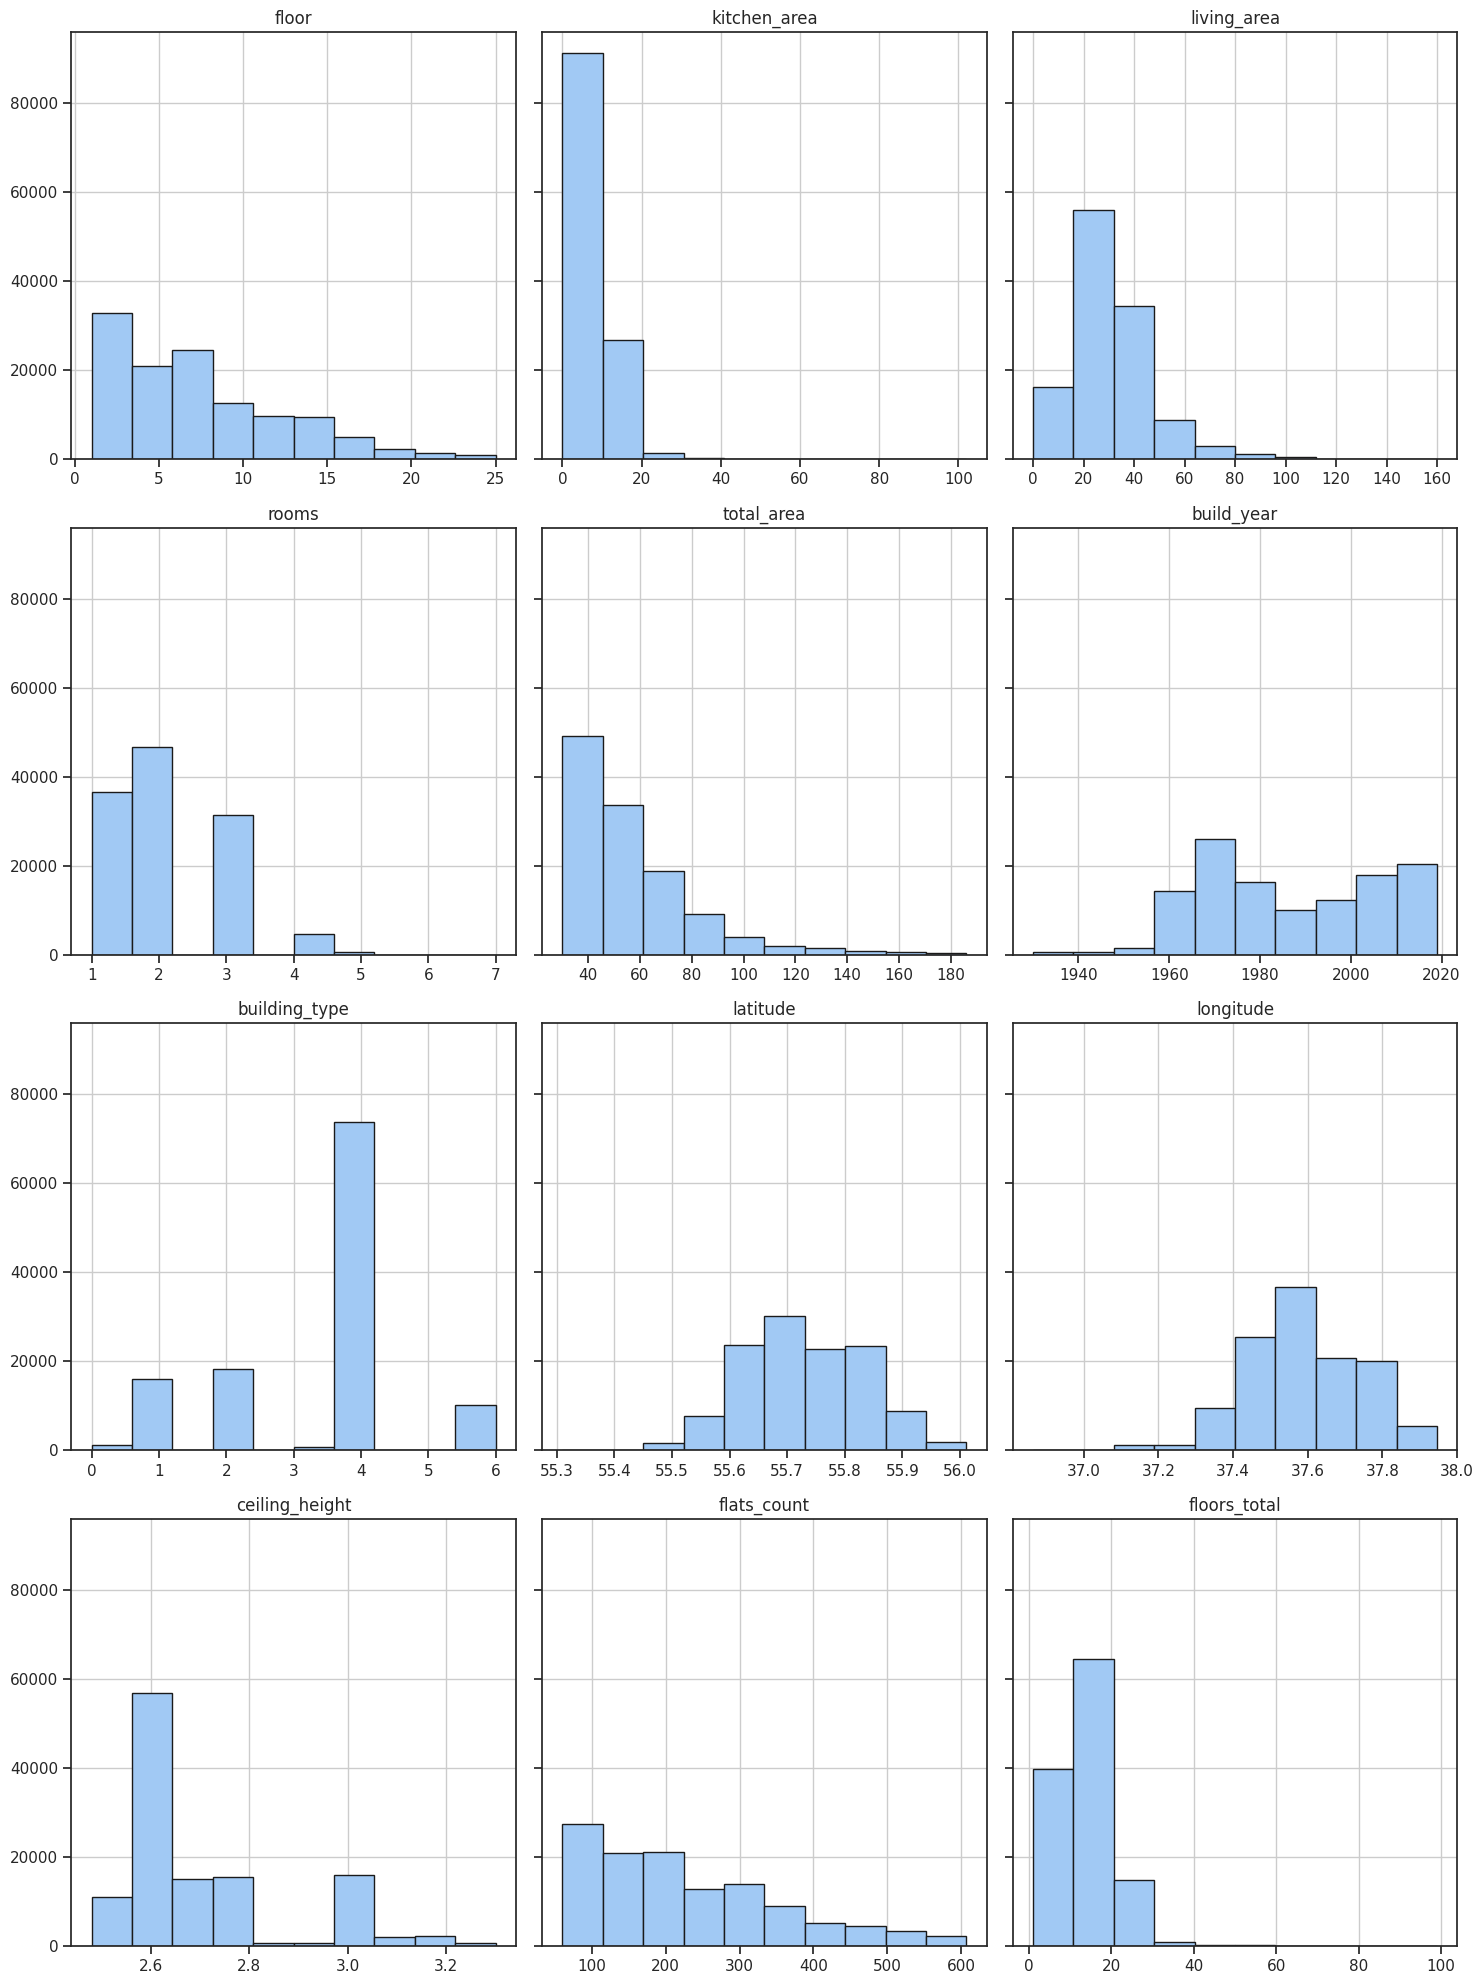


Описательная статистика числовых признаков:
                   count         mean         std          min          25%  \
floor           120118.0     7.310270    5.036944     1.000000     3.000000   
kitchen_area    120118.0     8.787528    4.390607     0.000000     6.200000   
living_area     120118.0    29.510262   18.068514     0.000000    19.000000   
rooms           120118.0     2.054430    0.880291     1.000000     1.000000   
total_area      120118.0    57.178375   23.989388    30.000000    39.000000   
build_year      120118.0  1986.860762   19.888037  1930.000000  1970.000000   
building_type   120118.0     3.417489    1.405681     0.000000     2.000000   
latitude        120118.0    55.729652    0.102923    55.309727    55.652493   
longitude       120118.0    37.592648    0.152252    36.864372    37.491287   
ceiling_height  120118.0     2.719910    0.165103     2.480000     2.640000   
flats_count     120118.0   229.037730  129.408994    60.000000   127.000000   
floors_

In [9]:
# Построение гистограмм для числовых признаков
df_nobool = features.select_dtypes(include=[np.number])
print(f"Найдено числовых колонок: {len(df_nobool.columns)}")
print(f"Колонки: {list(df_nobool.columns)}")
print(f"Размер df_nobool: {df_nobool.shape}")
print(f"Типы данных: {df_nobool.dtypes.value_counts()}")

if len(df_nobool.columns) > 0:
    # Создаем гистограммы напрямую без subplots
    df_nobool.hist(figsize=(15, 20), edgecolor="k", sharey=True)
    plt.tight_layout()
    plt.savefig('plots/numeric_features_histograms.png', dpi=150, bbox_inches='tight')
    plt.show()  # Используем plt.show() для отображения в Jupyter

    # Отображение описательной статистики для числовых признаков
    print("\nОписательная статистика числовых признаков:")
    print(df_nobool.describe().T)
else:
    print("Нет числовых колонок для построения гистограмм")

Булевые столбцы:

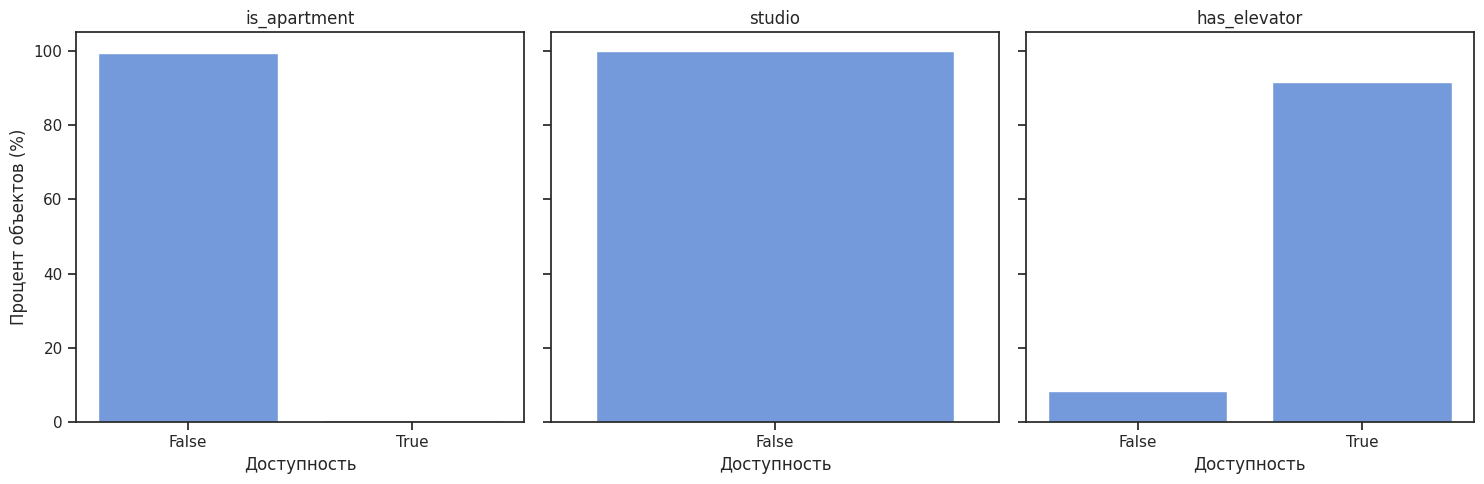

In [11]:
df_bool = df.select_dtypes(include="bool")
if len(df_bool.columns) > 0:
    fig, axes = plt.subplots(1, min(len(df_bool.columns), 3), figsize=(15, 5), sharey=True)
    if len(df_bool.columns) == 1:
        axes = [axes]
    
    for col, ax in zip(df_bool.columns.tolist(), axes):
        sns.countplot(
            x=col, data=df_bool, ax=ax, color="cornflowerblue", stat="percent"
        )
        ax.set_xlabel("Доступность")
        ax.set_ylabel("Процент объектов (%)")
        ax.set_title(col)
    plt.tight_layout()
    plt.savefig('plots/boolean_features_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

##### Анализ целевой переменной

Давайте перейдем к столбцу целевой переменной. Мы построим серию гистограмм, 
разбитых по количеству комнат, типу здания и наличию лифта:

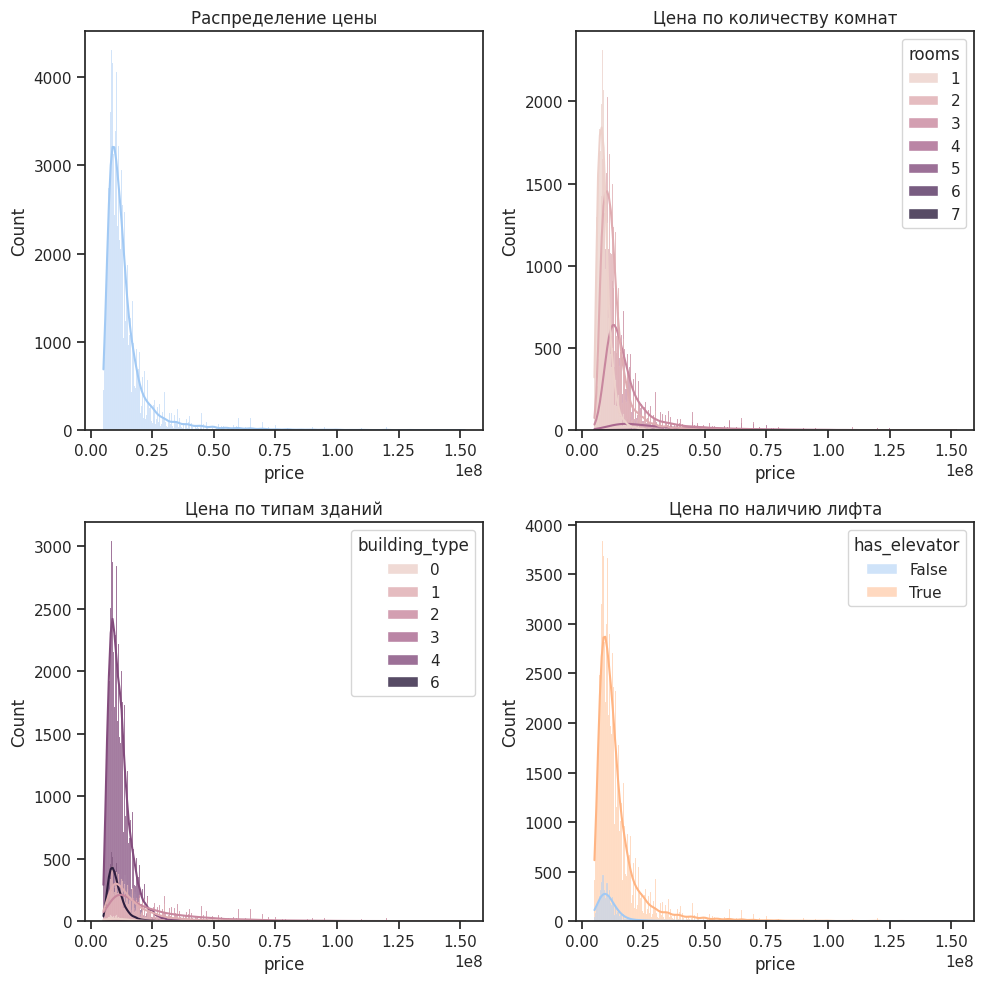

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(data=df, x="price", kde=True, ax=axes[0][0])
axes[0][0].set_title('Распределение цены')

if 'rooms' in df.columns:
    sns.histplot(
        data=df, x="price", hue="rooms", alpha=0.8, kde=True, ax=axes[0][1]
    )
    axes[0][1].set_title('Цена по количеству комнат')

if 'building_type' in df.columns:
    sns.histplot(
        data=df,
        x="price",
        hue="building_type",
        alpha=0.8,
        kde=True,
        ax=axes[1][0],
    )
    axes[1][0].set_title('Цена по типам зданий')

if 'has_elevator' in df.columns:
    sns.histplot(
        data=df, x="price", hue="has_elevator", alpha=0.5, kde=True, ax=axes[1][1]
    )
    axes[1][1].set_title('Цена по наличию лифта')

plt.tight_layout()
plt.savefig('plots/target_variable_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

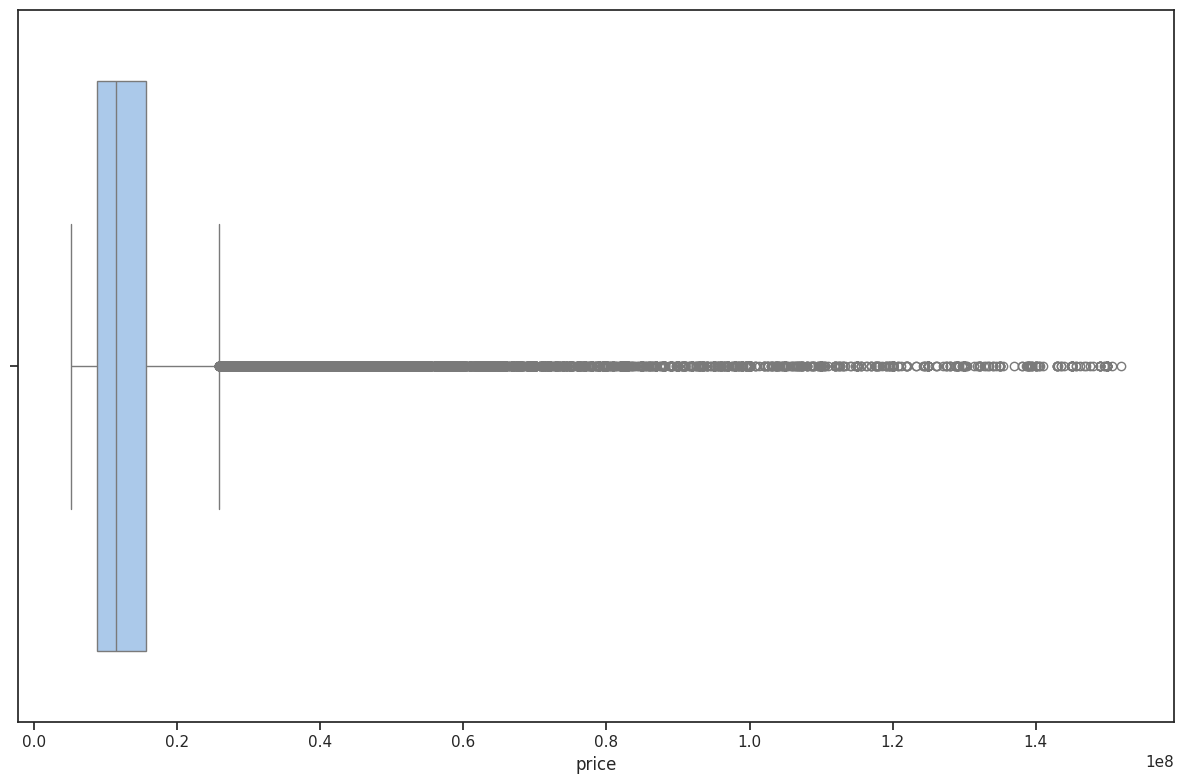

In [13]:
# Boxplot цены
sns.boxplot(data=df, x="price")
plt.tight_layout()
plt.savefig('plots/price_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

##### Корреляционный анализ с целевой переменной

Полная корреляционная матрица с целевой переменной:

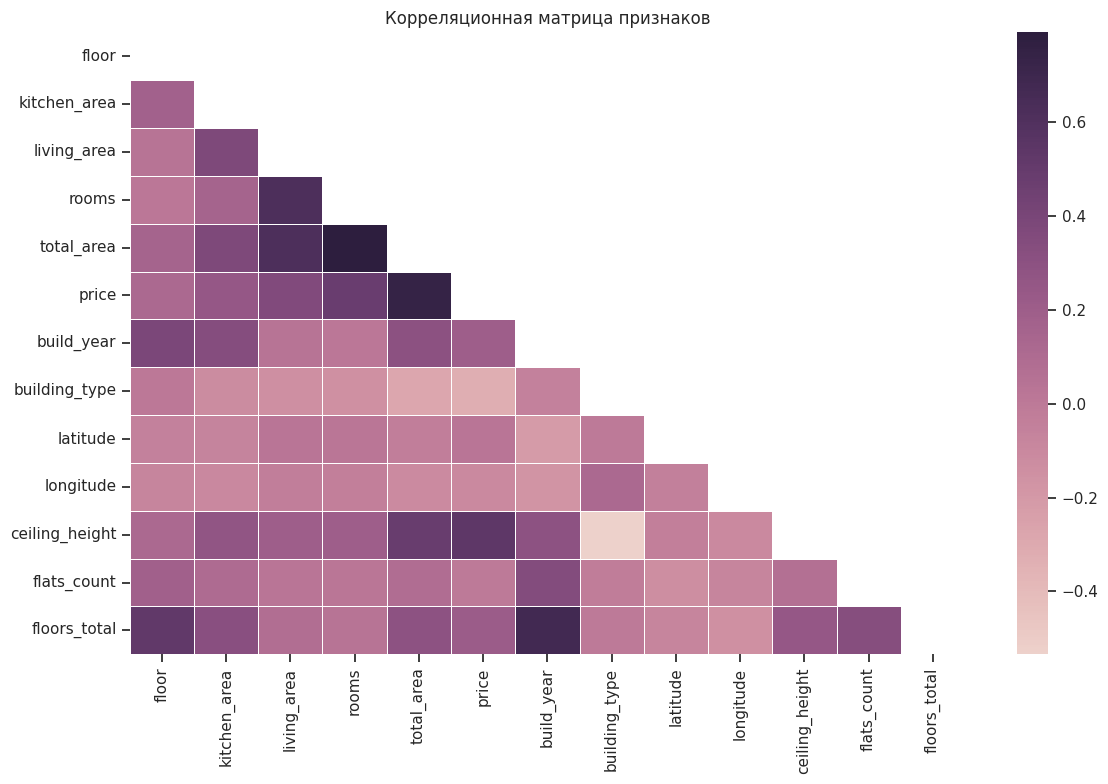

In [14]:
corr_matrix_full = df.select_dtypes(include=[np.number]).corr()
mask = np.zeros_like(corr_matrix_full)
mask[np.triu_indices_from(mask)] = True
corr_heatmap_full = sns.heatmap(
    corr_matrix_full,
    linewidth=0.5,
    mask=mask,
    cmap=sns.cubehelix_palette(as_cmap=True),
)
corr_heatmap_full.xaxis.tick_bottom()
corr_heatmap_full.yaxis.tick_left()
corr_heatmap_full.set(title="Корреляционная матрица признаков")
plt.tight_layout()
plt.savefig('plots/correlation_matrix_full.png', dpi=150, bbox_inches='tight')
plt.show()


Топ-5 факторов, влияющих на цену:
total_area        0.747813
ceiling_height    0.542401
rooms             0.477043
living_area       0.365343
building_type     0.324377
Name: price, dtype: float64


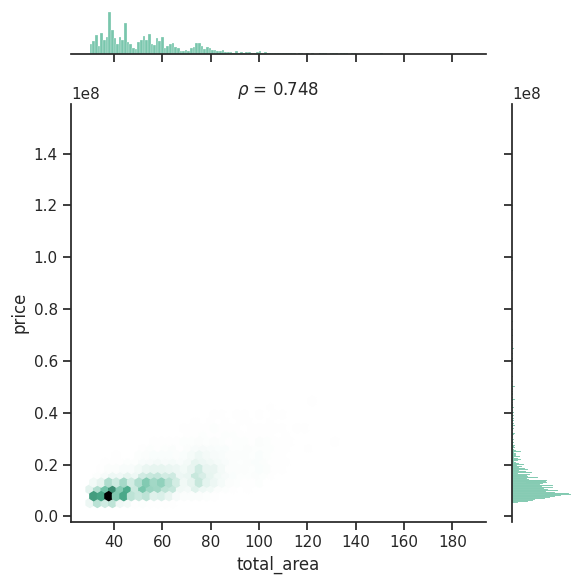

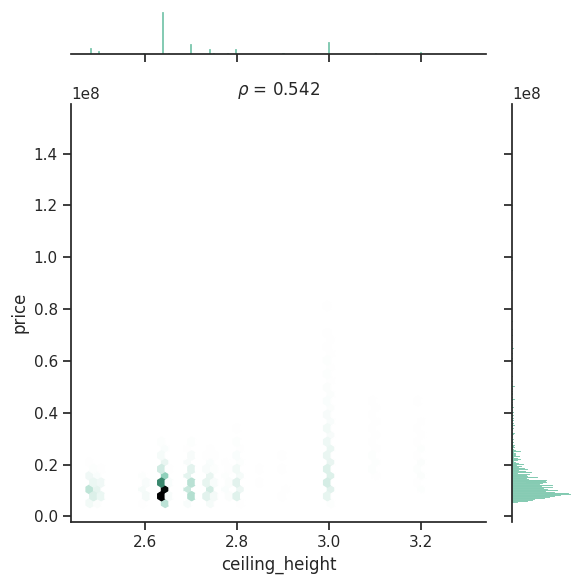

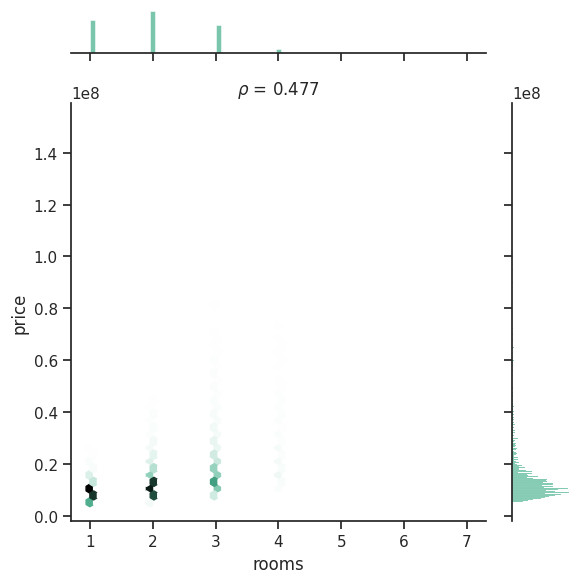

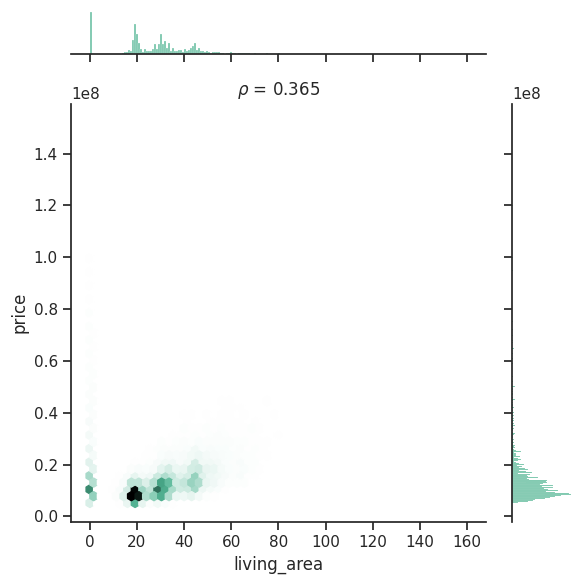

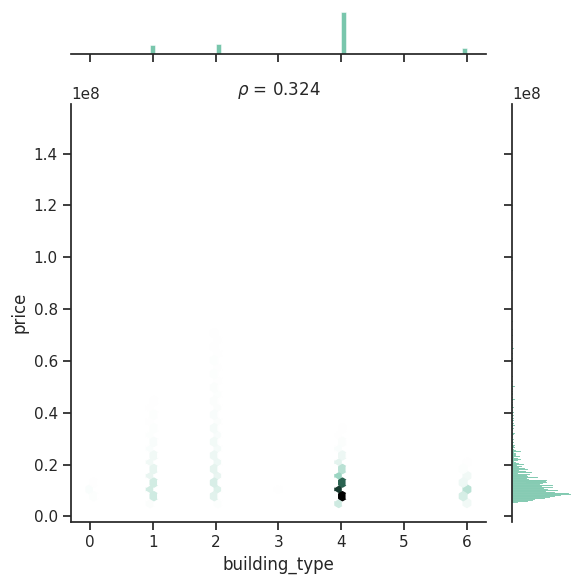

In [15]:
# Топ-5 факторов, влияющих на цену
price_factors_5 = (
    corr_matrix_full["price"].abs().sort_values(ascending=False)[1:].head()
)
print("\nТоп-5 факторов, влияющих на цену:")
print(price_factors_5)

# Совместные графики для топ-5 факторов
for col in price_factors_5.index.tolist():
    sns.jointplot(data=df, x=col, y="price", kind="hex", color="#4CB391")
    plt.title(rf"$\rho$ = {price_factors_5[col]:.3f}")
    plt.tight_layout()
    plt.savefig(f'plots/jointplot_{col}_vs_price.png', dpi=150, bbox_inches='tight')
    plt.show()

In [16]:
# === АНАЛИЗ ДАННЫХ ===
basic_info = {
    'shape': df.shape,
    'dtypes': df.dtypes.value_counts().to_dict(),
    'missing_values': df.isnull().sum().sum(),
    'memory_usage': df.memory_usage(deep=True).sum() / 1024**2  # MB
}

missing_values = df.isnull().sum()

logger.info(f"Пропущенные значения: {basic_info['missing_values']}")
logger.info(f"Использование памяти: {basic_info['memory_usage']:.1f} MB")
if missing_values.sum() > 0:
    logger.info("Обнаружены пропущенные значения в колонках:")
    for col, count in missing_values[missing_values > 0].items():
        logger.info(f"   {col}: {count}")

# === АНАЛИЗ ПРИЗНАКОВ ДЛЯ МОДЕЛИ ===
numeric_features = features.select_dtypes(include=[np.number]).columns
categorical_features = features.select_dtypes(include=['object', 'category']).columns
boolean_features = features.select_dtypes(include=['bool']).columns

logger.info(f"Числовых признаков: {len(numeric_features)}")
logger.info(f"Категориальных признаков: {len(categorical_features)}")
logger.info(f"Булевых признаков: {len(boolean_features)}")

# === АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
target_stats = {
    'mean': df['price'].mean(),
    'median': df['price'].median(),
    'std': df['price'].std(),
    'min': df['price'].min(),
    'max': df['price'].max(),
    'skewness': df['price'].skew(),
    'kurtosis': df['price'].kurtosis(),
    'cv': df['price'].std() / df['price'].mean(),
    'q25': df['price'].quantile(0.25),
    'q75': df['price'].quantile(0.75)
}

# === АНАЛИЗ КОРРЕЛЯЦИЙ ===
# Используем только числовые признаки для корреляций
numeric_df = df[numeric_features.tolist() + ['price']]
corr_matrix = numeric_df.corr()

# Получение топ корреляций
price_corr = corr_matrix['price'].abs().sort_values(ascending=False)[1:11]

# === АНАЛИЗ АНОМАЛИЙ ===
# Используем IQR метод для выявления выбросов
outliers_info = {}
for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_info[col] = {
        'count': outliers,
        'percentage': (outliers / len(df) * 100).round(2)
    }

# === КЛЮЧЕВЫЕ ИНСАЙТЫ ===
eda_insights = {
    'basic_info': basic_info,
    'target_stats': target_stats,
    'top_correlations': price_corr.head(5).to_dict(),
    'outliers_info': outliers_info,
    'feature_types': {
        'numeric': len(numeric_features),
        'categorical': len(categorical_features),
        'boolean': len(boolean_features)
    },
    'eda_completed': True,
    'execution_time': time.time() - start_time
}

# Логирование EDA результатов
log_eda_summary(eda_insights, verbose=False)

2025-09-21 21:07:29 - ml_project - INFO - Пропущенные значения: 0
2025-09-21 21:07:29 - ml_project - INFO - Использование памяти: 6.3 MB
2025-09-21 21:07:29 - ml_project - INFO - Числовых признаков: 12
2025-09-21 21:07:29 - ml_project - INFO - Категориальных признаков: 0
2025-09-21 21:07:29 - ml_project - INFO - Булевых признаков: 3


2025-09-21 21:07:29 - ml_project - INFO - EDA analysis completed - execution_time=166.11s, dataset_shape=(120118, 16), missing_values=0, memory_usage_mb=6.3, feature_types={'numeric': 12, 'categorical': 0, 'boolean': 3}


{'basic_info': {'shape': (120118, 16),
  'dtypes': {dtype('int32'): 7, dtype('float32'): 6, dtype('bool'): 3},
  'missing_values': 0,
  'memory_usage': 6.300561904907227},
 'target_stats': {'mean': 14777789.678008292,
  'median': 11500000.0,
  'std': 12166880.005796116,
  'min': 5200000,
  'max': 151958896,
  'skewness': 4.549483841022765,
  'kurtosis': 29.07175107487053,
  'cv': 0.8233220441553837,
  'q25': 8890000.0,
  'q75': 15700000.0},
 'top_correlations': {'total_area': 0.7478130201572213,
  'ceiling_height': 0.5424013014435166,
  'rooms': 0.47704326717926476,
  'living_area': 0.36534324489047537,
  'building_type': 0.32437656442418467},
 'outliers_info': {'floor': {'count': 2353, 'percentage': 1.96},
  'kitchen_area': {'count': 13869, 'percentage': 11.55},
  'living_area': {'count': 2863, 'percentage': 2.38},
  'rooms': {'count': 6, 'percentage': 0.0},
  'total_area': {'count': 5435, 'percentage': 4.52},
  'build_year': {'count': 0, 'percentage': 0.0},
  'building_type': {'count

##### Выводы EDA

Ключевые выводы из проведенного анализа:

1. **Корреляционные зависимости**: Основными факторами ценообразования являются 
   общая площадь (r = 0.748), высота потолков (r = 0.542) и количество комнат (r = 0.477). 
   Обнаружена сильная мультиколлинеарность между total_area и rooms (r = 0.791).

2. **Распределение целевой переменной**: Цена имеет очень высокую 
   правостороннюю асимметрию (skewness = 4.55) и экстремальные выбросы 
   (эксцесс = 29.07).

3. **Качество данных**: Датасет содержит 120,118 объектов без пропущенных 
   значений. Выявлены критические выбросы в ceiling_height (17.1%) и 
   экстремальные цены (>Q99: 1,186 объектов).

4. **Константные признаки**: Признак `studio` является константным (все значения False) 
   и должен быть удален из модели.

5. **Рекомендации по трансформациям**: Обязательно применить логарифмическое преобразование 
   цены и RobustScaler для обработки выбросов перед обучением модели.

6. **Выбор алгоритма**: Tree-based методы (CatBoost, XGBoost) наиболее подходящие для 
   данной задачи с нелинейными зависимостями и категориальными признаками.

In [17]:
# Краткий вывод результатов EDA
print("Сводка анализа EDA:")
dataset_shape = eda_insights['basic_info']['shape']
print(f"Датасет: {dataset_shape[0]:,} строк × {dataset_shape[1]} колонок")

feature_types = eda_insights['feature_types']
print(f"Признаки: {feature_types['numeric']} числовых, "
      f"{feature_types['categorical']} категориальных, "
      f"{feature_types['boolean']} булевых")

print(f"Пропущенные значения: {eda_insights['basic_info']['missing_values']}")
print(f"Время выполнения: {eda_insights['execution_time']:.2f}с")

top_corr = eda_insights['top_correlations']
top_feature = list(top_corr.keys())[0]
top_value = list(top_corr.values())[0]
print(f"Топ корреляция: {top_feature} = {top_value:.3f}")

Сводка анализа EDA:
Датасет: 120,118 строк × 16 колонок
Признаки: 12 числовых, 0 категориальных, 3 булевых
Пропущенные значения: 0
Время выполнения: 166.11с
Топ корреляция: total_area = 0.748


In [18]:
# Удаляем studio на основе результатов EDA
df = df.drop('studio', axis=1)

# Разделение признаков и целевой переменной
target = df["price"]
features = df.drop("price", axis=1)

# Разделение данных
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

logger.info(f"Разделение: {features_train.shape[0]:,} / {features_test.shape[0]:,}")

# === ЛОГ-ТРАНСФОРМАЦИЯ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
# для обработки правосторонней асимметрии и выбросов

# Сохраняем исходные значения для сравнения метрик
target_train_original = target_train.copy()
target_test_original = target_test.copy()

# Применяем log1p трансформацию (более стабильная чем log)
target_train_log = np.log1p(target_train.values)
target_test_log = np.log1p(target_test.values)

logger.info("Исходное распределение цены:")
logger.info(f"   Среднее: {target_train_original.mean():,.0f}")
logger.info(f"   Медиана: {target_train_original.median():,.0f}")
logger.info(f"   Стд. отклонение: {target_train_original.std():,.0f}")
logger.info(f"   Асимметрия: {target_train_original.skew():.2f}")

logger.info("После log1p трансформации:")
logger.info(f"   Среднее: {target_train_log.mean():.2f}")
logger.info(f"   Медиана: {np.median(target_train_log):.2f}")
logger.info(f"   Стд. отклонение: {target_train_log.std():.2f}")
logger.info(f"   Асимметрия: {pd.Series(target_train_log).skew():.2f}")

# Обновляем переменные для дальнейшего использования
target_train = pd.Series(target_train_log, index=target_train.index)
target_test = pd.Series(target_test_log, index=target_test.index)

logger.info("Лог-трансформация применена успешно")

2025-09-21 21:08:19 - ml_project - INFO - Разделение: 90,088 / 30,030
2025-09-21 21:08:19 - ml_project - INFO - Исходное распределение цены:
2025-09-21 21:08:19 - ml_project - INFO -    Среднее: 14,774,173
2025-09-21 21:08:19 - ml_project - INFO -    Медиана: 11,500,000
2025-09-21 21:08:19 - ml_project - INFO -    Стд. отклонение: 12,176,002
2025-09-21 21:08:19 - ml_project - INFO -    Асимметрия: 4.57
2025-09-21 21:08:19 - ml_project - INFO - После log1p трансформации:
2025-09-21 21:08:19 - ml_project - INFO -    Среднее: 16.34
2025-09-21 21:08:19 - ml_project - INFO -    Медиана: 16.26
2025-09-21 21:08:19 - ml_project - INFO -    Стд. отклонение: 0.51
2025-09-21 21:08:19 - ml_project - INFO -    Асимметрия: 1.33
2025-09-21 21:08:19 - ml_project - INFO - Лог-трансформация применена успешно


#### Этап 3: Генерация признаков и обучение модели

In [19]:
# Применение pipeline генерации признаков
(features_train_combined, features_test_combined, 
 sklearn_preprocessor, autofeat_model, combined_feature_names) = (
    feature_engineering_pipeline(
        features_train, features_test, target_train, verbose=True
    )
)

# === Обучение модели после генерации признаков (ЭТАП 3) ===
logger.info("\nОбучение модели после генерации признаков")

# Создание модели после генерации признаков
feateng_model = CatBoostRegressor(
    random_seed=RANDOM_STATE, 
    verbose=False,
    iterations=600,
    depth=6,
    learning_rate=0.1
)

feateng_model.fit(features_train_combined, target_train.values)

# Предсказания и метрики для модели после генерации признаков
feateng_pred_log = feateng_model.predict(features_test_combined)
feateng_pred = np.expm1(feateng_pred_log)  # Обратная трансформация

feateng_rmse = np.sqrt(mean_squared_error(target_test_original.values, feateng_pred))
feateng_r2 = r2_score(target_test_original.values, feateng_pred)
feateng_mae = mean_absolute_error(target_test_original.values, feateng_pred)

# Логирование результатов модели
feateng_metrics = {
    'rmse': feateng_rmse,
    'r2': feateng_r2,
    'mae': feateng_mae
}
log_model_performance_summary("Инженерия признаков завершена", feateng_metrics, verbose=False)

2025-09-21 21:08:32 - ml_project - INFO - Генерация признаков
2025-09-21 21:08:32 - ml_project - INFO - Исходный размер: (90088, 14)
2025-09-21 21:08:32 - ml_project - INFO - Числовых признаков: 12
2025-09-21 21:08:32 - ml_project - INFO - Категориальных признаков: 0
2025-09-21 21:08:32 - ml_project - INFO - Применение sklearn Pipeline.
/home/mle-user/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
2025-09-21 21:08:36 - ml_project - INFO - sklearn Pipeline применен за 3.99s: (90088, 480)
2025-09-21 21:08:36 - ml_project - INFO - Применение autofeat...
2025-09-21 21:09:52 - ml_project - INFO - ✅ Autofeat завершен за 75.46s
2025-09-21 21:09:52 - ml_project - INFO - Новых признаков создано: 37
2025-09-21 21:09:52 - ml_project - INFO - Итого

#### Этап 4: Отбор признаков и обучение модели

2025-09-21 21:15:30 - ml_project - INFO - Этап 4: Отбор признаков mlxtend
2025-09-21 21:15:30 - ml_project - INFO - ============================================================
2025-09-21 21:15:30 - ml_project - INFO - Отбор признаков с MLXTEND
2025-09-21 21:15:30 - ml_project - INFO - Исходное количество признаков: 517
2025-09-21 21:15:30 - ml_project - INFO - Используем обученную модель для отбора признаков
2025-09-21 21:15:30 - ml_project - INFO - Всего признаков: 517
2025-09-21 21:20:32 - ml_project - INFO - Предварительный отбор: топ-10 признаков из них топ-5 важных
2025-09-21 21:20:32 - ml_project - INFO -    1. rs__floor: 0.0003
2025-09-21 21:20:32 - ml_project - INFO -    2. rs__kitchen_area: 0.0152
2025-09-21 21:20:32 - ml_project - INFO -    3. rs__living_area: 0.0000
2025-09-21 21:20:32 - ml_project - INFO -    4. rs__rooms: 0.0000
2025-09-21 21:20:32 - ml_project - INFO -    5. rs__total_area: 0.5023
2025-09-21 21:20:32 - ml_project - INFO - Forward Selection.
2025-09-21 21

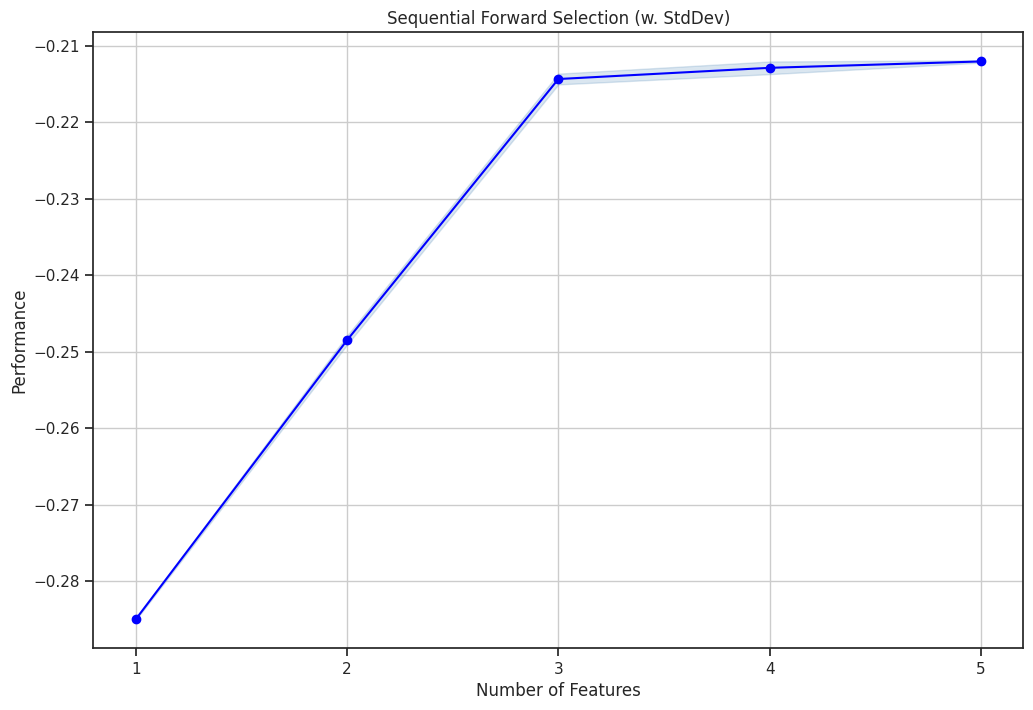

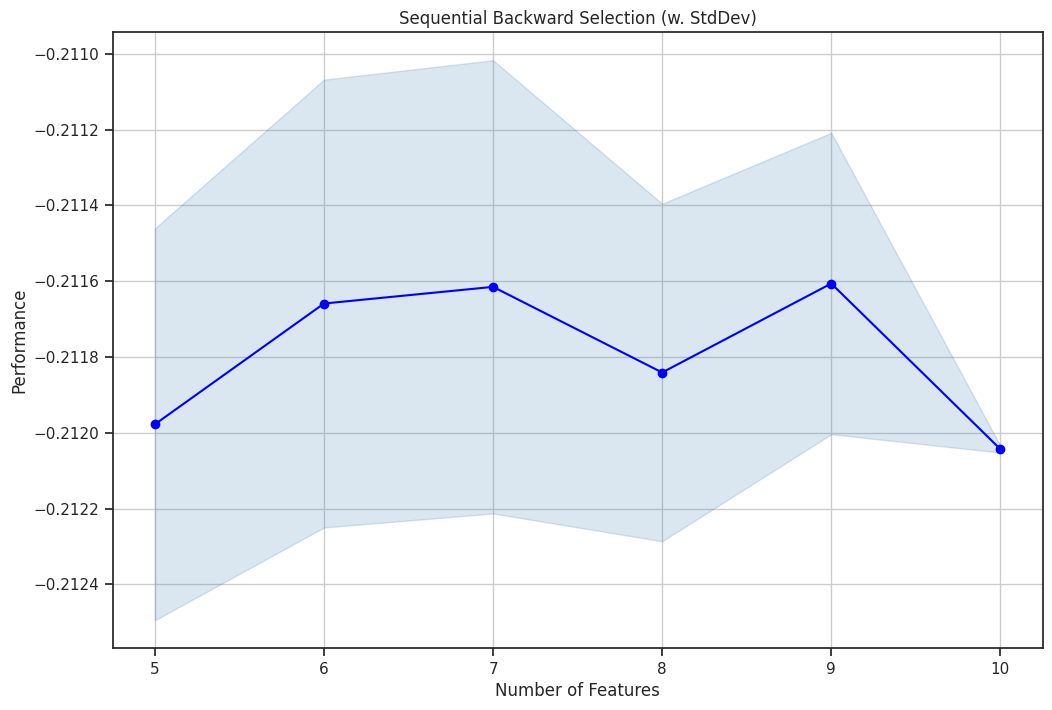

2025-09-21 21:23:19 - ml_project - INFO - Создание графиков важности признаков.


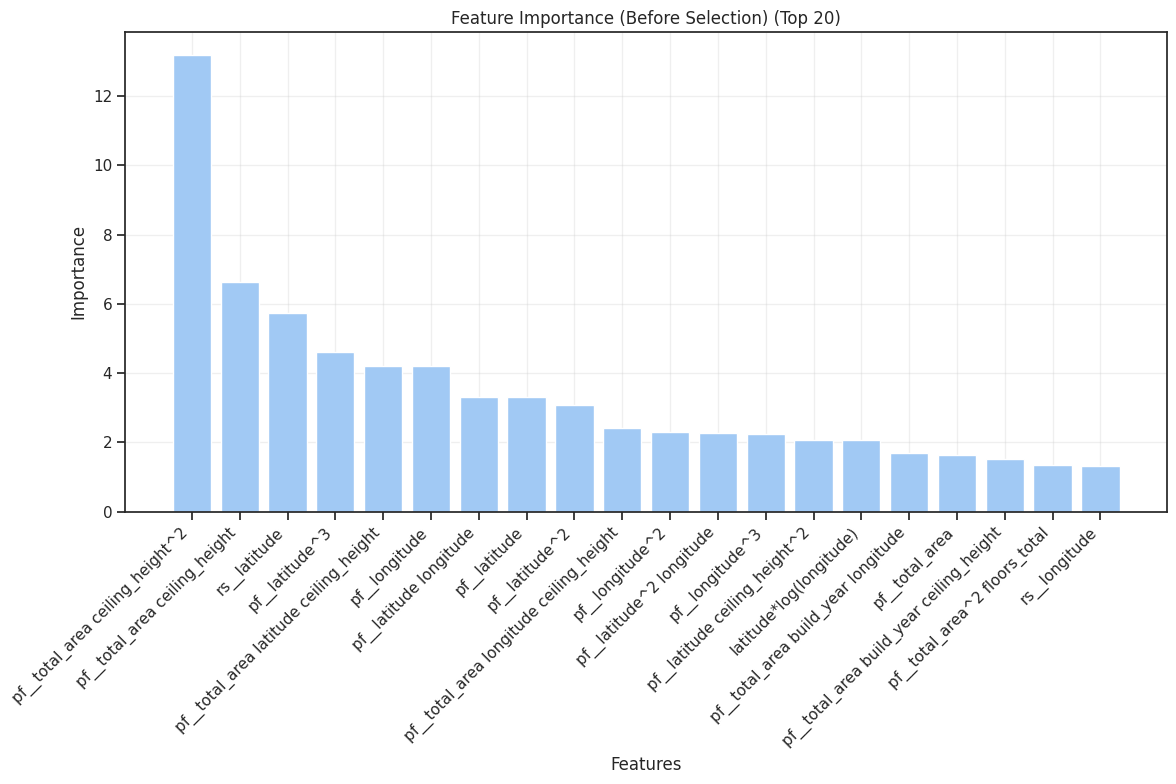

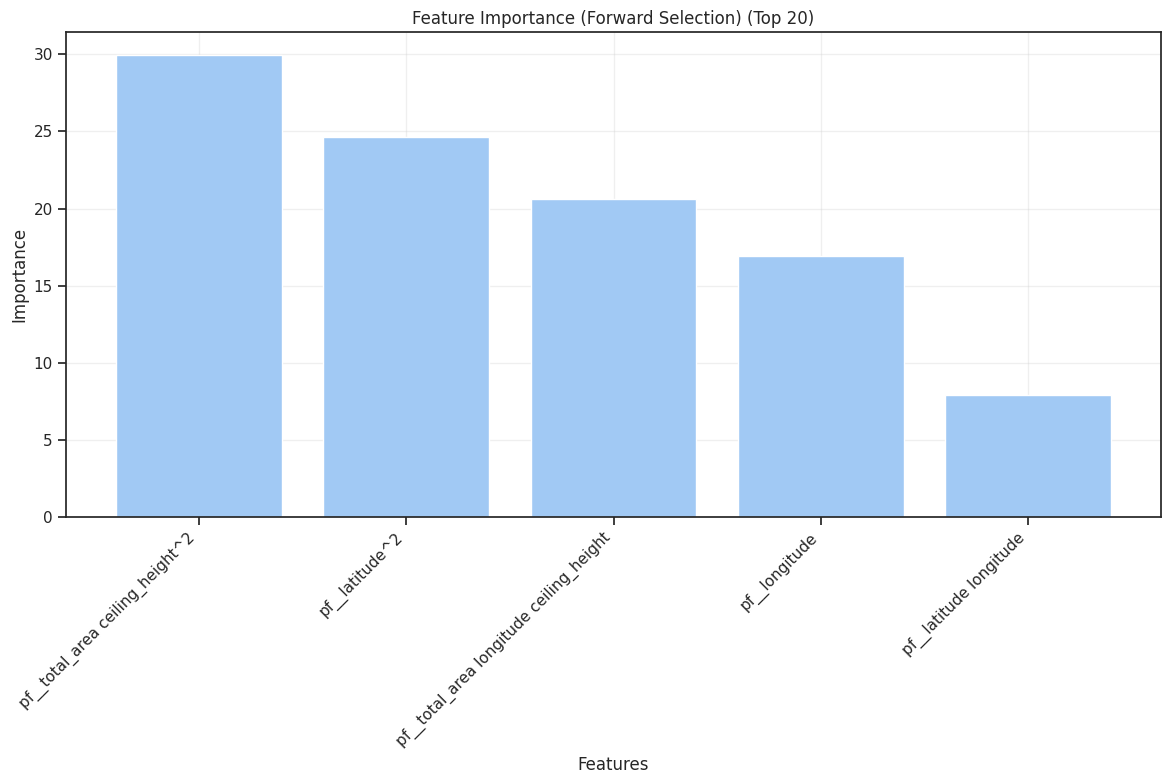

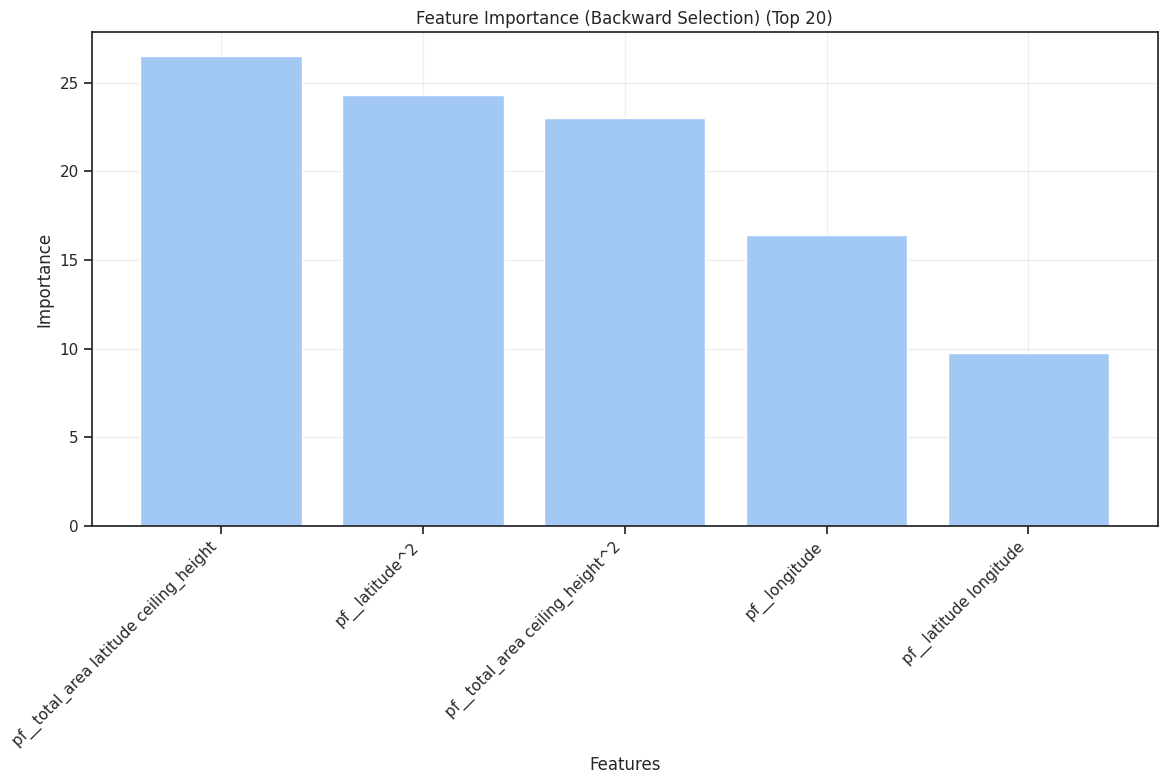

2025-09-21 21:23:26 - ml_project - INFO - Анализ результатов отбора признаков.
2025-09-21 21:23:28 - ml_project - INFO - Forward Selection: 5 признаков (RMSE: 0.212)
2025-09-21 21:23:28 - ml_project - INFO - Backward Selection: 5 признаков (RMSE: 0.212)
2025-09-21 21:23:28 - ml_project - INFO - Пересечение: 4 признаков (R²: 0.812)
2025-09-21 21:23:28 - ml_project - INFO - Объединение: 6 признаков (R²: 0.814)
2025-09-21 21:23:28 - ml_project - INFO - Выбран метод: union с 6 признаками
2025-09-21 21:23:28 - ml_project - INFO - Отбор признаков завершен за 475.95s
2025-09-21 21:23:28 - ml_project - INFO - 
Отбор признаков завершен:
2025-09-21 21:23:28 - ml_project - INFO -    Исходно: 517 признаков
2025-09-21 21:23:28 - ml_project - INFO -    Отобрано: 6 признаков
2025-09-21 21:23:28 - ml_project - INFO -    Сокращение: 98.8%
2025-09-21 21:23:28 - ml_project - INFO - 
Обучение модели после отбора признаков
2025-09-21 21:23:36 - ml_project - INFO - Модель отбора признаков training completed

In [20]:
logger.info("Этап 4: Отбор признаков mlxtend")

# Применение отбора признаков mlxtend
selected_features, sfs_forward, sfs_backward = (
    feature_selection_mlxtend(
        features_train_combined, target_train.values, 
        combined_feature_names, verbose=True
    )
)

# Обновление данных с отобранными признаками
# Используем только доступные признаки 
features_train_selected = pd.DataFrame(
    features_train_combined[:, :len(combined_feature_names)], 
    columns=combined_feature_names
)[selected_features].values
features_test_selected = pd.DataFrame(
    features_test_combined[:, :len(combined_feature_names)], 
    columns=combined_feature_names
)[selected_features].values

logger.info("\nОтбор признаков завершен:")
logger.info(f"   Исходно: {features_train_combined.shape[1]} признаков")
logger.info(f"   Отобрано: {len(selected_features)} признаков")
reduction_pct = (
    (features_train_combined.shape[1] - len(selected_features)) / 
    features_train_combined.shape[1] * 100
)
logger.info(f"   Сокращение: {reduction_pct:.1f}%")

# === Обучение модели после отбора признаков (этап 4) ===
logger.info("\nОбучение модели после отбора признаков")

# Создание модели после отбора признаков
featselect_model = CatBoostRegressor(
    random_seed=RANDOM_STATE, 
    verbose=False,
    iterations=600,
    depth=6,
    learning_rate=0.1
)

featselect_model.fit(features_train_selected, target_train.values)

# Предсказания и метрики для модели после отбора признаков
featselect_pred_log = featselect_model.predict(features_test_selected)
featselect_pred = np.expm1(featselect_pred_log)  # Обратная трансформация

featselect_rmse = np.sqrt(mean_squared_error(target_test_original.values, featselect_pred))
featselect_r2 = r2_score(target_test_original.values, featselect_pred)
featselect_mae = mean_absolute_error(target_test_original.values, featselect_pred)

# Логирование результатов модели
featselect_metrics = {
    'rmse': featselect_rmse,
    'r2': featselect_r2,
    'mae': featselect_mae
}
log_model_performance_summary("Модель отбора признаков", featselect_metrics, verbose=False)

#### Этап 5: Настройка гиперпараметров и обучение модели

In [23]:
logger.info("Этап 5: Двойная настройка гиперпараметров")

# Двойная настройка гиперпараметров с MLflowCallback
with mlflow.start_run(run_name="stage_5_hyperparameter_tuning", experiment_id=experiment_id) as run:
    best_params, best_score, best_method, rscv, study = hyperparameter_tuning_dual(
        features_train_selected, target_train.values, experiment_id, verbose=True
    )
    
    # Логируем результаты настройки гиперпараметров
    mlflow.log_params(best_params)
    mlflow.log_param("tuning_method", best_method)
    mlflow.log_metric("best_cv_score", -best_score)
    mlflow.log_param("stage", "hyperparameter_tuning")

2025-09-21 21:44:25 - ml_project - INFO - Этап 5: Двойная настройка гиперпараметров
2025-09-21 21:44:25 - ml_project - INFO - Двойная настройка гиперпараметров
2025-09-21 21:44:25 - ml_project - INFO - 1. HalvingRandomSearchCV...
2025-09-21 21:44:49 - ml_project - INFO - HalvingRandomSearchCV завершен за 23.60s: RMSE = 0
2025-09-21 21:44:49 - ml_project - INFO - 2. Optuna настройка с MLflowCallback...
[I 2025-09-21 21:44:49,290] A new study created in memory with name: no-name-570224c1-3c32-4d2c-b5f4-745f1728b77c


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-21 21:45:28,761] Trial 0 finished with value: -0.2098559644138064 and parameters: {'learning_rate': 0.030710573677773714, 'depth': 8, 'iterations': 866, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 4, 'max_ctr_complexity': 2}. Best is trial 0 with value: -0.2098559644138064.
[I 2025-09-21 21:46:05,166] Trial 1 finished with value: -0.2166231834073068 and parameters: {'learning_rate': 0.011900590783184251, 'depth': 8, 'iterations': 801, 'l2_leaf_reg': 7.372653200164409, 'min_data_in_leaf': 1, 'max_ctr_complexity': 8}. Best is trial 0 with value: -0.2098559644138064.
[I 2025-09-21 21:46:18,645] Trial 2 finished with value: -0.2116784703867475 and parameters: {'learning_rate': 0.12106896936002161, 'depth': 4, 'iterations': 591, 'l2_leaf_reg': 2.650640588680904, 'min_data_in_leaf': 7, 'max_ctr_complexity': 5}. Best is trial 0 with value: -0.2098559644138064.
[I 2025-09-21 21:46:36,778] Trial 3 finished with value: -0.21620101387148152 and parameters: {'learning_rate': 0

2025-09-21 21:48:43 - ml_project - INFO - Optuna завершен за 234.49s: RMSE = 0
2025-09-21 21:48:43 - ml_project - INFO - Лучший метод: Optuna
2025-09-21 21:48:43 - ml_project - INFO - Лучший RMSE: 0
2025-09-21 21:48:43 - ml_project - INFO - Время настройки: 234.49s
2025-09-21 21:48:43 - ml_project - INFO - Общее время: 258.10s
2025-09-21 21:48:43 - ml_project - INFO - Лучшие параметры:
2025-09-21 21:48:43 - ml_project - INFO -    learning_rate: 0.059963338824126605
2025-09-21 21:48:43 - ml_project - INFO -    depth: 8
2025-09-21 21:48:43 - ml_project - INFO -    iterations: 544
2025-09-21 21:48:43 - ml_project - INFO -    l2_leaf_reg: 2.763845761772307
2025-09-21 21:48:43 - ml_project - INFO -    min_data_in_leaf: 1
2025-09-21 21:48:43 - ml_project - INFO -    max_ctr_complexity: 3


[I 2025-09-21 21:48:43,663] Trial 9 finished with value: -0.20833510183772241 and parameters: {'learning_rate': 0.059963338824126605, 'depth': 8, 'iterations': 544, 'l2_leaf_reg': 2.763845761772307, 'min_data_in_leaf': 1, 'max_ctr_complexity': 3}. Best is trial 9 with value: -0.20833510183772241.


#### Обучение финальной модели

In [24]:
logger.info("Обучение финальной модели")

# Создание финальной модели
final_model = CatBoostRegressor(**best_params)
final_model.fit(features_train_selected, target_train.values)

# Предсказания и метрики (с обратной трансформацией)
y_pred_log = final_model.predict(features_test_selected)
y_pred = np.expm1(y_pred_log)  # Обратная трансформация log1p

# Метрики в исходной шкале для сравнения с baseline
final_rmse = np.sqrt(mean_squared_error(target_test_original.values, y_pred))
final_r2 = r2_score(target_test_original.values, y_pred)
final_mae = mean_absolute_error(target_test_original.values, y_pred)

# Сравнение с baseline
baseline_improvement_rmse = (baseline_rmse - final_rmse) / baseline_rmse * 100
baseline_improvement_r2 = (final_r2 - baseline_r2) / baseline_r2 * 100

logger.info("\nСравнение с baseline:")
logger.info(f"  RMSE: {baseline_rmse:.3f} → {final_rmse:.3f} ({baseline_improvement_rmse:+.1f}%)")
logger.info(f"  R²: {baseline_r2:.3f} → {final_r2:.3f} ({baseline_improvement_r2:+.1f}%)")

2025-09-21 21:58:39 - ml_project - INFO - Обучение финальной модели


0:	learn: 0.4847993	total: 35.5ms	remaining: 19.3s
1:	learn: 0.4643423	total: 52ms	remaining: 14.1s
2:	learn: 0.4455712	total: 70.4ms	remaining: 12.7s
3:	learn: 0.4279546	total: 87ms	remaining: 11.7s
4:	learn: 0.4120230	total: 104ms	remaining: 11.2s
5:	learn: 0.3971677	total: 120ms	remaining: 10.7s
6:	learn: 0.3830580	total: 136ms	remaining: 10.4s
7:	learn: 0.3701970	total: 152ms	remaining: 10.2s
8:	learn: 0.3587194	total: 168ms	remaining: 10s
9:	learn: 0.3481792	total: 185ms	remaining: 9.86s
10:	learn: 0.3380798	total: 200ms	remaining: 9.71s
11:	learn: 0.3285538	total: 217ms	remaining: 9.63s
12:	learn: 0.3201143	total: 233ms	remaining: 9.53s
13:	learn: 0.3123308	total: 251ms	remaining: 9.49s
14:	learn: 0.3052080	total: 267ms	remaining: 9.41s
15:	learn: 0.2986830	total: 284ms	remaining: 9.38s
16:	learn: 0.2929873	total: 308ms	remaining: 9.56s
17:	learn: 0.2875141	total: 324ms	remaining: 9.48s
18:	learn: 0.2825191	total: 343ms	remaining: 9.47s
19:	learn: 0.2782020	total: 359ms	remaining

2025-09-21 21:58:48 - ml_project - INFO - 
Сравнение с baseline:
2025-09-21 21:58:48 - ml_project - INFO -   RMSE: 4157670.131 → 4678509.352 (-12.5%)
2025-09-21 21:58:48 - ml_project - INFO -   R²: 0.880 → 0.851 (-3.3%)


543:	learn: 0.2029970	total: 9.24s	remaining: 0us


#### Логирование артефактов в MLflow

In [25]:
logger.info("MLFLOW логирование по этапам")

# Этап 2: EDA - MLflow логирование
with mlflow.start_run(run_name="stage_2_eda", experiment_id=experiment_id) as run:
    # Батчевое логирование параметров
    mlflow_params = {
        "eda_execution_time": eda_insights['execution_time'],
        "dataset_rows": eda_insights['basic_info']['shape'][0],
        "dataset_columns": eda_insights['basic_info']['shape'][1],
        "missing_values_count": eda_insights['basic_info']['missing_values'],
        "memory_usage_mb": eda_insights['basic_info']['memory_usage'],
        "numeric_features": eda_insights['feature_types']['numeric'],
        "categorical_features": eda_insights['feature_types']['categorical'],
        "boolean_features": eda_insights['feature_types']['boolean'],
        "stage": "eda"
    }
    
    # Батчевое логирование метрик
    mlflow_metrics = {
        "target_mean": eda_insights['target_stats']['mean'],
        "target_std": eda_insights['target_stats']['std'],
        "target_skewness": eda_insights['target_stats']['skewness'],
        "target_cv": eda_insights['target_stats']['cv']
    }
    
    # Корреляции как метрики
    for feature, corr in eda_insights['top_correlations'].items():
        mlflow_metrics[f"correlation_{feature}"] = corr
    
    # Логирование в MLflow
    log_mlflow_summary("EDA", 
                      params=mlflow_params, 
                      metrics=mlflow_metrics,
                      artifacts={"plots/": "eda_plots"})

# Этап 3: Feature Engineering
with mlflow.start_run(run_name="stage_3_feature_engineering", experiment_id=experiment_id) as run:
    # Логирование sklearn модели
    mlflow.sklearn.log_model(sklearn_preprocessor, "sklearn_preprocessor")
    
    # Autofeat не имеет flavor - логируем как артефакт
    import pickle
    with open("models/autofeat_model.pkl", "wb") as f:
        pickle.dump(autofeat_model, f)
    mlflow.log_artifact("models/autofeat_model.pkl", "autofeat_model")
    
    # Регистрация модели после генерации признаков
    feateng_signature = mlflow.models.infer_signature(
        features_train_combined, feateng_model.predict(features_train_combined)
    )
    
    mlflow.catboost.log_model(
        feateng_model,
        artifact_path="models",
        registered_model_name="feateng_model",
        signature=feateng_signature,
        input_example=features_train_combined[:5]
    )
    logger.info("Модель после генерации признаков зарегистрирована в MLflow Model Registry")
    
    # Логирование параметров и метрик
    mlflow.log_params({
        "autofeat_enabled": True,
        "features_created": len(autofeat_model.new_feat_cols_) if autofeat_model is not None else 0,
        "feateng_iterations": 600,
        "feateng_depth": 6,
        "feateng_learning_rate": 0.1,
        "autofeat_feateng_steps": 2,
        "autofeat_max_gb": 16,
        "autofeat_transformations": "exp,log",
        "stage": "feature_engineering"
    })
    
    mlflow.log_metrics({
        "feateng_test_rmse": feateng_rmse,
        "feateng_test_r2": feateng_r2,
        "feateng_test_mae": feateng_mae,
        "feateng_improvement_rmse": (baseline_rmse - feateng_rmse) / baseline_rmse * 100,
        "feateng_improvement_r2": (feateng_r2 - baseline_r2) / baseline_r2 * 100
    })
    
    # Логирование окружения (environment)
    mlflow.log_param("python_version", "3.8+")
    mlflow.log_param("sklearn_version", "1.3.0")
    mlflow.log_param("catboost_version", "1.2.2")
    mlflow.log_param("autofeat_version", "0.0.7")

# Этап 4: Feature Selection
with mlflow.start_run(run_name="stage_4_feature_selection", experiment_id=experiment_id) as run:
    # Регистрация модели после отбора признаков
    featselect_signature = mlflow.models.infer_signature(
        features_train_selected, featselect_model.predict(features_train_selected)
    )
    
    mlflow.catboost.log_model(
        featselect_model,
        artifact_path="models",
        registered_model_name="featselect_model",
        signature=featselect_signature,
        input_example=features_train_selected[:5]
    )
    logger.info("Модель после отбора признаков зарегистрирована в MLflow Model Registry")
    
    # Логирование параметров
    mlflow.log_params({
        "selection_method": "mlxtend_sfs",
        "selected_features_count": len(selected_features),
        "forward_features_count": len(sfs_forward.k_feature_names_),
        "backward_features_count": len(sfs_backward.k_feature_names_),
        "featselect_iterations": 600,
        "featselect_depth": 6,
        "featselect_learning_rate": 0.1,
        "sfs_k_features": 15,
        "sfs_cv_folds": 2,
        "sfs_catboost_iterations": 50,
        "sfs_catboost_depth": 4,
        "stage": "feature_selection"
    })
    
    # Логирование метрик
    mlflow.log_metrics({
        "forward_score": -sfs_forward.k_score_,
        "backward_score": -sfs_backward.k_score_,
        "featselect_test_rmse": featselect_rmse,
        "featselect_test_r2": featselect_r2,
        "featselect_test_mae": featselect_mae,
        "featselect_improvement_rmse": (baseline_rmse - featselect_rmse) / baseline_rmse * 100,
        "featselect_improvement_r2": (featselect_r2 - baseline_r2) / baseline_r2 * 100
    })
    
    # Логирование артефактов
    mlflow.log_artifacts("fs_assets/", "feature_selection_plots")
    
    # Логирование окружения (environment)
    mlflow.log_param("python_version", "3.8+")
    mlflow.log_param("mlxtend_version", "0.22.0")
    mlflow.log_param("catboost_version", "1.2.2")

# Этап 5: Hyperparameter Tuning (часть 1 - процесс настройки уже логирован выше)

# Этап 5: Финальная модель (часть 2 - обучение и регистрация финальной модели)
with mlflow.start_run(run_name="stage_5_final_model", experiment_id=experiment_id) as run:
    mlflow.log_params(best_params)
    mlflow.log_param("stage", "hyperparameter_tuning_final")
    mlflow.log_metrics({
        "test_rmse": final_rmse,
        "test_r2": final_r2,
        "test_mae": final_mae,
        "baseline_improvement_rmse": baseline_improvement_rmse,
        "baseline_improvement_r2": baseline_improvement_r2
    })
    
    # Регистрация модели в Model Registry
    # Используем лог-трансформированные данные для signature
    model_signature = mlflow.models.infer_signature(
        features_train_selected, final_model.predict(features_train_selected)
    )
    
    # Регистрация финальной модели
    model_info = mlflow.catboost.log_model(
        final_model,
        artifact_path="models",
        registered_model_name="final_model",
        signature=model_signature,
        input_example=features_train_selected[:5],
    )
    logger.info("Финальная модель зарегистрирована в MLflow Model Registry")

2025-09-21 21:59:10 - ml_project - INFO - MLFLOW логирование по этапам
2025-09-21 21:59:11,115 INFO: Found credentials in environment variables.
2025-09-21 21:59:12 - ml_project - INFO - MLflow logging completed for EDA
2025/09/21 21:59:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'feateng_model' already exists. Creating a new version of this model...
2025/09/21 21:59:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: feateng_model, version 15
Created version '15' of model 'feateng_model'.
2025-09-21 21:59:25 - ml_project - INFO - Модель после генерации признаков зарегистрирована в MLflow Model Registry
Registered model 'featselect_model' already exists. Creating a new version of this model...
2025/09/21 21:59:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: featselect_

#### Проект успешно завершен

In [26]:
# Итоговые результаты проекта
print("Итоговые результаты проекта:")
print(f"Базовый RMSE: {baseline_rmse:,.3f} ₽")
print(f"Финальный RMSE: {final_rmse:,.3f} ₽")
print(f"Улучшение: {baseline_improvement_rmse:+.1f}%")
print(f"Финальный R²: {final_r2:.3f}")
print(f"Использовано признаков: {len(selected_features)}")
print(f"Эксперимент MLflow: {experiment_id}")
print("Проект успешно завершен!")

Итоговые результаты проекта:
Базовый RMSE: 4,157,670.131 ₽
Финальный RMSE: 4,678,509.352 ₽
Улучшение: -12.5%
Финальный R²: 0.851
Использовано признаков: 6
Эксперимент MLflow: 2
Проект успешно завершен!
